<a href="https://www.kaggle.com/code/mohamedelbadri01/sf-plot-scores?scriptVersionId=210364992" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [8]:
import os



import calendar



import xarray as xr



import ipywidgets as widgets



import matplotlib.pyplot as plt



import cartopy.crs as ccrs



import cartopy.feature as cfeature



import numpy as np



import seaborn as sns



import geopandas as gpd

In [9]:
config = dict(



    list_vars = ['2m_temperature', ],



    hcstarty = 1993,



    hcendy = 2016,



    start_month = 11,



)



details="_1993-2016_monthly_mean_11_234_45_-30_-2.5_60"



available_files=["ukmo_602","meteo_france_8","ecmwf_51","eccc_3","eccc_2","dwd_21","cmcc_35"]



VARNAMES = {'t2m': '2m-T'}

periods=["djf","mam","jja","son"]



SCOREDIR = "/kaggle/input/scores"

config = dict(list_vars=['2m_temperature'], hcstarty=1993, hcendy=2016, start_month=11)

details = "_1993-2016_monthly_mean_5_234_45_-30_-2.5_60"

available_files = ["ukmo_602", "meteo_france_8", "ecmwf_51", "eccc_3", "eccc_2", "dwd_21", "cmcc_35"]

VARNAMES = {'t2m': '2m-T'}

metrics = ["corr", "rsquared", "rmse","corr_pval"]



period_to_month = {

    "djf": 11,

    "mam": 2,

    "jja": 5,

    "son": 8

    }


# A-DETERLINISTIC

In [10]:
shapefile_path = '/kaggle/input/morrocan-shape-file/maroc-world.shp'

shp = gpd.read_file(shapefile_path,encoding='latin1')

## A-1 CORRELATION

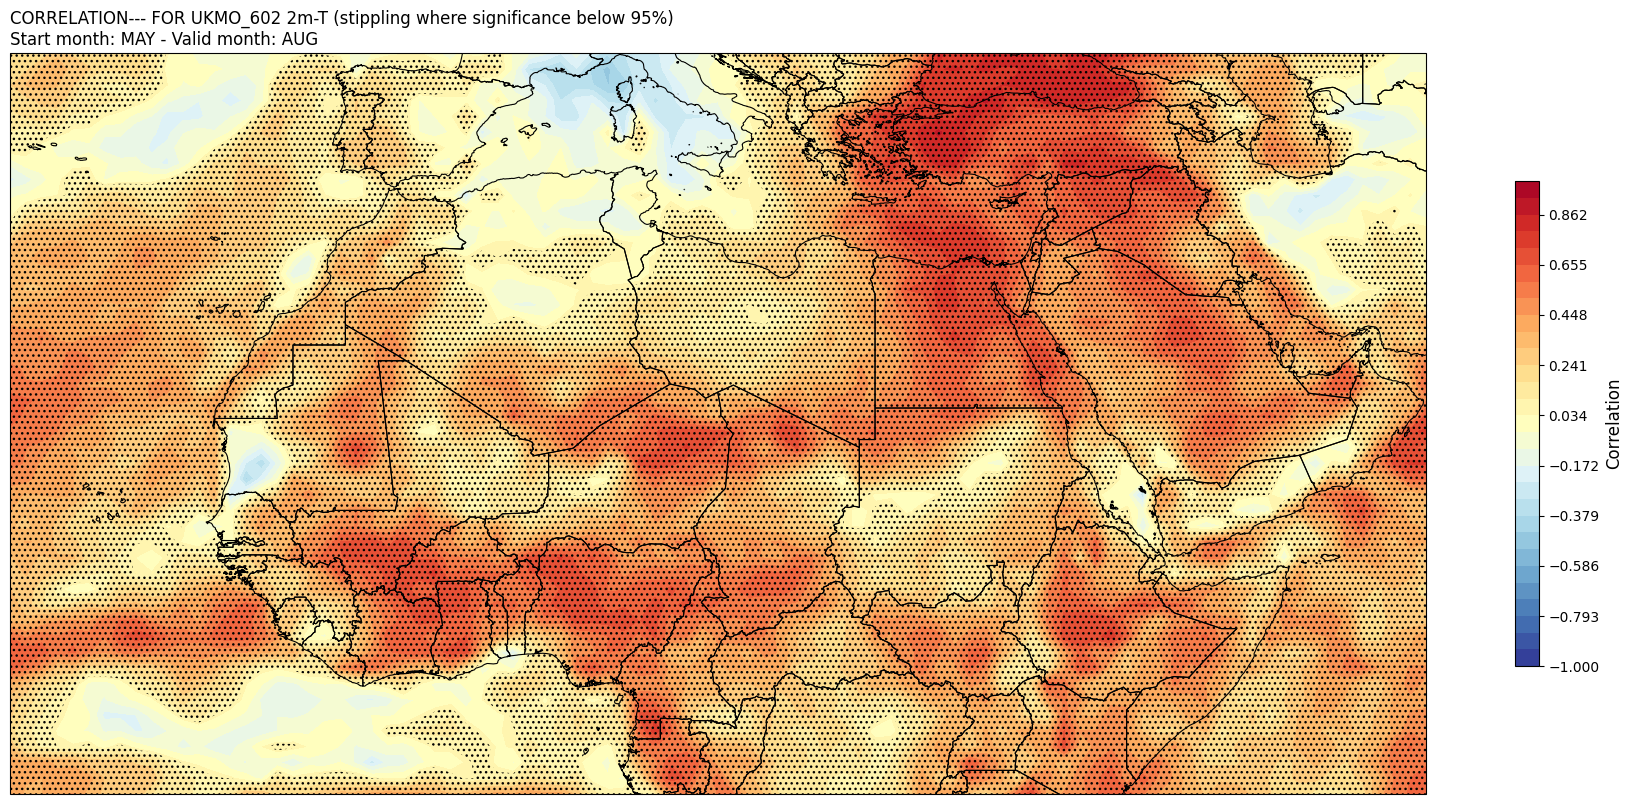

In [11]:
file_dropdown = widgets.Dropdown(



    options=available_files,



    description='CENTER'

)

def load_data(file_name, aggr, metric,period):

# Get the corresponding month

    mois = period_to_month.get(period)

    file_link = f'{SCOREDIR}/{file_name}_1993-2016_monthly_mean_{mois}_234_45_-30_-2.5_60_{period}.{aggr}.{metric}.nc'

    corr = xr.open_dataset(file_link)

    corr = corr.assign_coords(lon=(((corr.lon + 180) % 360) - 180)).sortby('lon')

    return corr





def plot_corr(file_name, aggr, fcmonth, period):

    config = dict(

        list_vars=['2m_temperature'],

        hcstarty=1993,

        hcendy=2016,

        start_month=period_to_month.get(period),

    )



    origin_labels = {'institution': f'{file_name}', 'metric': "correlation"}

    METR = load_data(file_name, aggr, "corr", period)

    METR_pvalue = load_data(file_name, aggr, "corr_pval", period)



    tit_line1 = '{metric}---'.format(**origin_labels).upper() + " FOR " + file_name.upper()

    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'



    if aggr == '1m':

        validmonth = config['start_month'] + (fcmonth - 1)

        validmonth = validmonth if validmonth <= 12 else validmonth - 12

        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

    elif aggr == '3m':

        validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]

        tit_line2 = tit_line2_base + f' - Valid months: {period}'

    else:

        raise ValueError(f'Unexpected aggregation {aggr}')



    # Select data for the chosen forecast month

    THISMETR = METR.sel(forecastMonth=fcmonth)

    THISMETR_PVAL = METR_pvalue.sel(forecastMonth=fcmonth)



    for var in THISMETR.data_vars:

        fig = plt.figure(figsize=(18, 10))

        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.set_extent([np.nanmin(THISMETR_PVAL[var].lon), np.nanmax(THISMETR_PVAL[var].lon), np.nanmin(THISMETR_PVAL[var].lat), np.nanmax(THISMETR_PVAL[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region



        # Plot shapefile instead of borders

        

        # ax.add_feature()



        METRVALUES = THISMETR[var].values

        METR_P_VALUES = THISMETR_PVAL[var].values



        if METRVALUES.T.shape == (THISMETR[var].lat.size, THISMETR[var].lon.size):

            METRVALUES = METRVALUES.T

            METR_P_VALUES = METR_P_VALUES.T



        plt.contourf(

            THISMETR[var].lon, THISMETR[var].lat, METRVALUES,

            levels=np.linspace(-1, 1, 30),

            cmap='RdYlBu_r'

        )

        cb = plt.colorbar(shrink=0.5)

        cb.ax.set_ylabel("Correlation", fontsize=12)



        origylim = ax.get_ylim()

        plt.contourf(THISMETR_PVAL[var].lon, THISMETR_PVAL[var].lat, METRVALUES,

                     levels=[0.05, np.inf], hatches=['...', None], colors='none')



        shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)



        if ax.get_ylim() != origylim:

            ax.set_ylim(origylim)



        plt.title(f"{tit_line1} {VARNAMES[var]} (stippling where significance below 95%)\n{tit_line2}", loc='left')

        plt.tight_layout()

        # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/corr/CORR_UNIQUE_{file_name}_{period}.png")

        plt.show()





aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')



fcmonth_slider = widgets.IntSlider(value=4, min=2, max=4, step=1, description='Forecast Month:')



period_dropdown=widgets.Dropdown(options=periods,value="jja",description="period")



# metric_droptown=widgets.Dropdown(options=metrics,value="corr",description="Metric")



# Display the interactive plot



widgets.interactive(plot_corr,period=period_dropdown,file_name=file_dropdown, aggr=aggr_dropdown, fcmonth=fcmonth_slider)

In [12]:
# for file_name in available_files:

#     for period in periods:

#         plot_corr(file_name,"3m", 4,period)

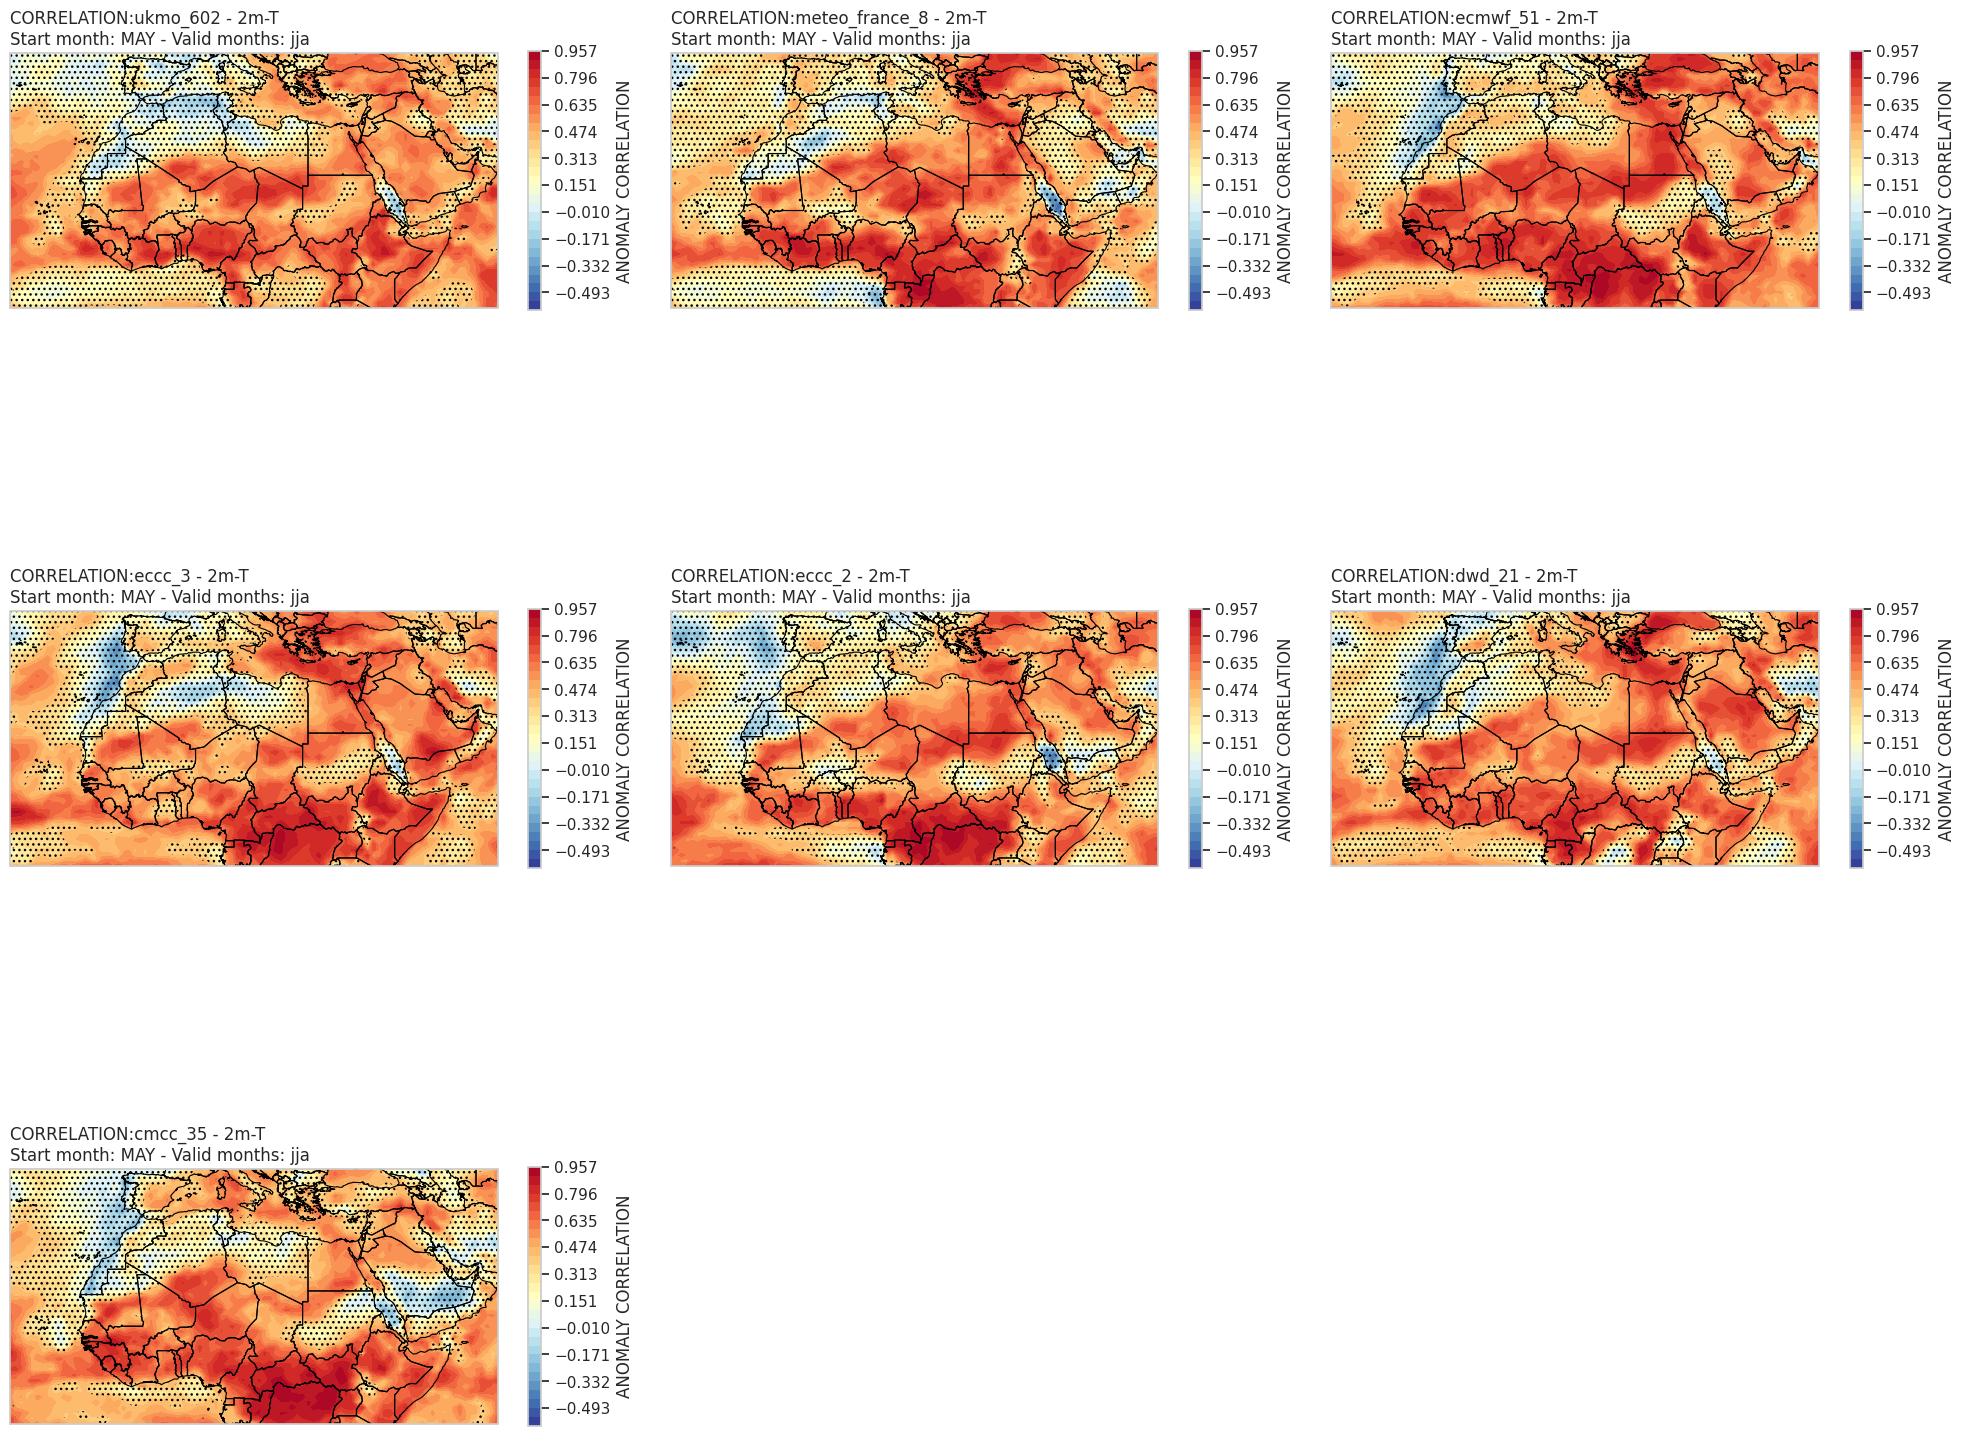

In [33]:
# Set constants



config = dict(list_vars=['2m_temperature'], hcstarty=1993, hcendy=2016, start_month=11)

details = "_1993-2016_monthly_mean_5_234_45_-30_-2.5_60"

available_files = ["ukmo_602", "meteo_france_8", "ecmwf_51", "eccc_3", "eccc_2", "dwd_21", "cmcc_35"]

VARNAMES = {'t2m': '2m-T'}

# metrics = ["corr", "rsquared", "rmse","corr_pval"]

# ukmo_602_1993-2016_monthly_mean_8_234_45_-30_-2.5_60_son.3m.corr.nc

# Load the datasets based on selected file, aggregation, and metric



period_to_month = {

    "djf": 11,

    "mam": 2,

    "jja": 5,

    "son": 8

    }



file_dropdown = widgets.Dropdown(



    options=available_files,



    description='CENTER'

)



def load_data(file_name,aggr,metric,period):

# Get the corresponding month

    mois = period_to_month.get(period)

    file_link = f'{SCOREDIR}/{file_name}_1993-2016_monthly_mean_{mois}_234_45_-30_-2.5_60_{period}.{aggr}.{metric}.nc'

    corr = xr.open_dataset(file_link)

    corr = corr.assign_coords(lon=(((corr.lon + 180) % 360) - 180)).sortby('lon')

    return corr



# Define the plot function with 3 columns layout

def plot_all_centers(aggr, fcmonth, period):

    config = dict(

        list_vars=['2m_temperature', ],

        hcstarty=1993,

        hcendy=2016,

        start_month=period_to_month.get(period),

    )

    

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols  # Calculate the number of rows needed



    # Determine global min and max for the metric

    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data(file_name, aggr, "corr", period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))

    

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})

    axes = axes.flatten()  # Flatten the axes array for easy iteration



    for i, (ax, file_name) in enumerate(zip(axes, available_files)):

        METR = load_data(file_name, aggr, "corr", period)

        METR_PVAL = load_data(file_name, aggr, "corr_pval", period)

        

        tit_line1 = f"{'CORRELATION'.upper()}:{file_name}"

        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'



        # Determine the valid month(s) for title

        if aggr == '1m':

            validmonth = config['start_month'] + (fcmonth - 1)

            validmonth = validmonth if validmonth <= 12 else validmonth - 12

            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

        elif aggr == '3m':

            validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]

            tit_line2 = tit_line2_base + f' - Valid months: {period}'

        else:

            raise ValueError(f'Unexpected aggregation {aggr}')



        # Select data for the chosen forecast month

        THISMETR = METR.sel(forecastMonth=fcmonth)

        THISMETR_PVAL = METR_PVAL.sel(forecastMonth=fcmonth)



        # Plot each variable for this center

        for var in THISMETR.data_vars:

            METRVALUES = THISMETR[var].values

            METR_P_VALUES = THISMETR_PVAL[var].values

            if METRVALUES.T.shape == (THISMETR[var].lat.size, THISMETR[var].lon.size):

                METRVALUES = METRVALUES.T

                METR_P_VALUES=METR_P_VALUES.T



            im = ax.contourf(

                THISMETR[var].lon, THISMETR[var].lat, METRVALUES,

                levels=np.linspace(global_min, global_max, 30),  # Use global min and max

                cmap='RdYlBu_r'

            )

            ax.set_extent([np.nanmin(THISMETR[var].lon), np.nanmax(THISMETR[var].lon), np.nanmin(THISMETR[var].lat), np.nanmax(THISMETR[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region



            cb = fig.colorbar(im, ax=ax, shrink=0.4)

            cb.ax.set_ylabel("ANOMALY CORRELATION".upper(), fontsize=12)



            shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

            ax.set_title(f"{tit_line1} - {VARNAMES.get(var, var)}\n{tit_line2}", loc='left')





            ax.contourf(THISMETR_PVAL[var].lon, THISMETR_PVAL[var].lat, METR_P_VALUES,levels=[0.05, np.inf], hatches=['...', None], colors='None')





    # Hide any unused subplots

    for j in range(i + 1, len(axes)):

        fig.delaxes(axes[j])



    plt.tight_layout()

    # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/corr/CORR_{period}.png")

    plt.show()



periods=["djf","mam","jja","son"]

# Create interactive widgets for `aggr`, `fcmonth`, and metric selection

aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='3m', description='Aggregation:')

fcmonth_slider = widgets.IntSlider(value=4, min=2, max=4, step=1, description='Forecast Month:')

period_dropdown=widgets.Dropdown(options=periods,value="jja",description="period")

# Display the interactive plot

widgets.interactive(plot_all_centers, period=period_dropdown,aggr=aggr_dropdown, fcmonth=fcmonth_slider)

In [14]:
# for aggr in ["3m"]:

#     for period in periods:

#             for fcmonth in [4]:

#                 plot_all_centers(aggr, fcmonth,period)

## A-2 RMSE-R2

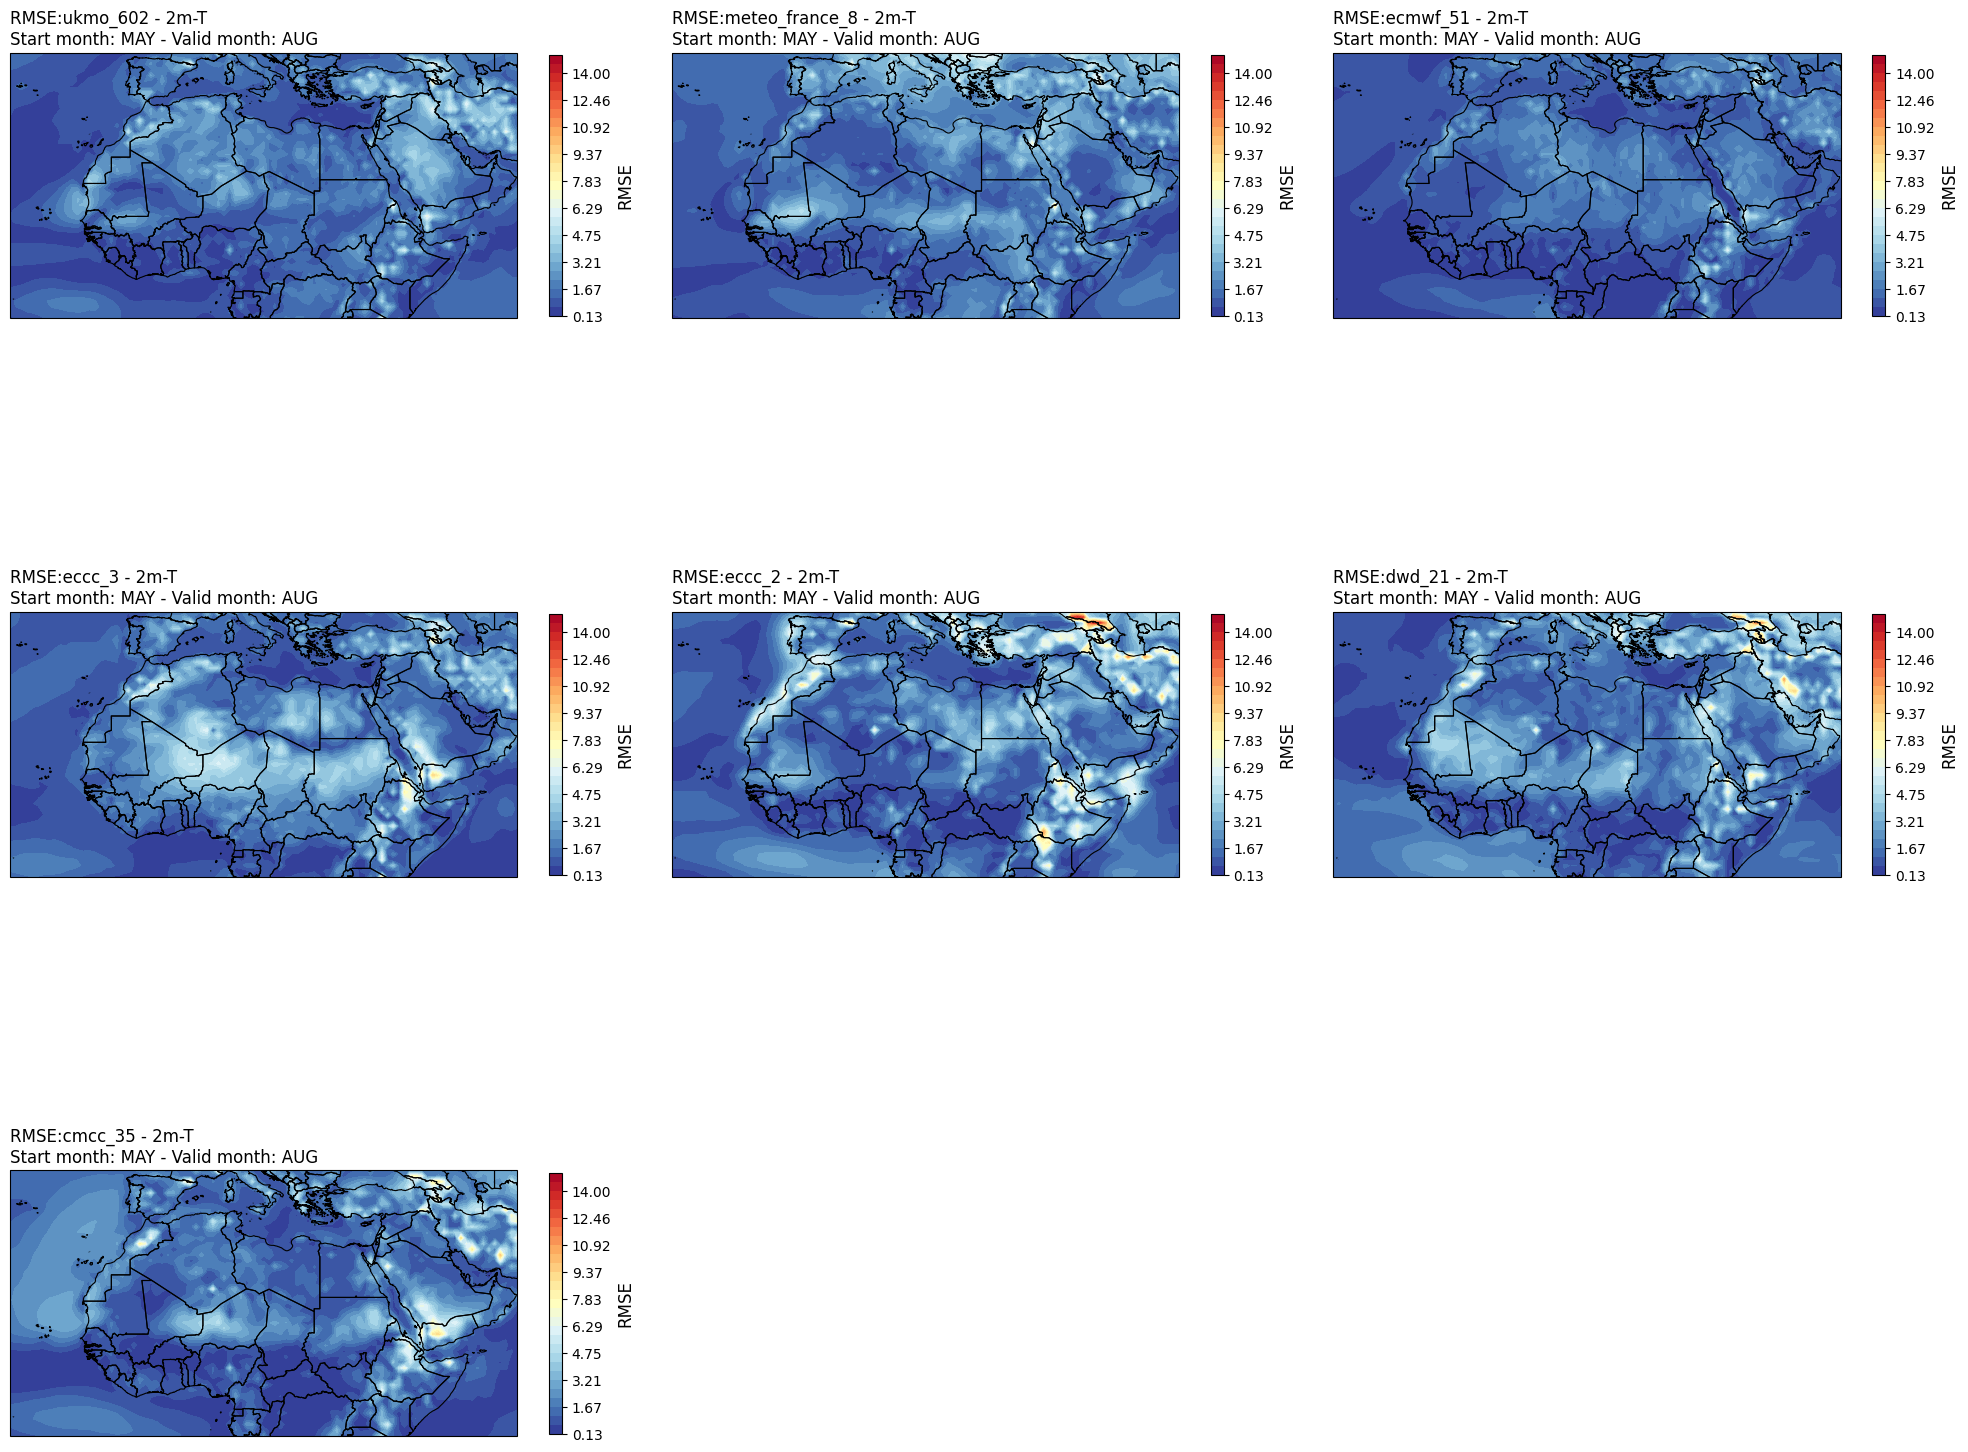

In [15]:
# Set constants



config = dict(list_vars=['2m_temperature'], hcstarty=1993, hcendy=2016, start_month=11)

details = "_1993-2016_monthly_mean_5_234_45_-30_-2.5_60"

available_files = ["ukmo_602", "meteo_france_8", "ecmwf_51", "eccc_3", "eccc_2", "dwd_21", "cmcc_35"]

VARNAMES = {'t2m': '2m-T'}

metrics = [ "rsquared", "rmse"]

# ukmo_602_1993-2016_monthly_mean_8_234_45_-30_-2.5_60_son.3m.corr.nc

# Load the datasets based on selected file, aggregation, and metric



period_to_month = {

    "djf": 11,

    "mam": 2,

    "jja": 5,

    "son": 8

    }



file_dropdown = widgets.Dropdown(



    options=available_files,



    description='CENTER'

)



def load_data(file_name, aggr, metric,period):

# Get the corresponding month

    mois = period_to_month.get(period)

    file_link = f'{SCOREDIR}/{file_name}_1993-2016_monthly_mean_{mois}_234_45_-30_-2.5_60_{period}.{aggr}.{metric}.nc'

    corr = xr.open_dataset(file_link)

    corr = corr.assign_coords(lon=(((corr.lon + 180) % 360) - 180)).sortby('lon')

    return corr



# Define the plot function with 3 columns layout

def plot_all_centers(aggr, fcmonth, metric, period):

    config = dict(

        list_vars=['2m_temperature', ],

        hcstarty=1993,

        hcendy=2016,

        start_month=period_to_month.get(period),

    )

    

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols  # Calculate the number of rows needed



    # Determine global min and max for the metric

    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data(file_name, aggr, metric, period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))

    

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})

    axes = axes.flatten()  # Flatten the axes array for easy iteration



    for i, (ax, file_name) in enumerate(zip(axes, available_files)):

        METR = load_data(file_name, aggr, metric, period)

        tit_line1 = f"{metric.upper()}:{file_name}"

        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'



        # Determine the valid month(s) for title

        if aggr == '1m':

            validmonth = config['start_month'] + (fcmonth - 1)

            validmonth = validmonth if validmonth <= 12 else validmonth - 12

            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

        elif aggr == '3m':

            validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]

            tit_line2 = tit_line2_base + f' - Valid months: {period}'

        else:

            raise ValueError(f'Unexpected aggregation {aggr}')



        # Select data for the chosen forecast month

        THISMETR = METR.sel(forecastMonth=fcmonth)



        # Plot each variable for this center

        for var in THISMETR.data_vars:

            METRVALUES = THISMETR[var].values

            if METRVALUES.T.shape == (THISMETR[var].lat.size, THISMETR[var].lon.size):

                METRVALUES = METRVALUES.T



            im = ax.contourf(

                THISMETR[var].lon, THISMETR[var].lat, METRVALUES,

                levels=np.linspace(global_min, global_max, 30),  # Use global min and max

                cmap='RdYlBu_r'

            )

            ax.set_extent([np.nanmin(THISMETR[var].lon), np.nanmax(THISMETR[var].lon), np.nanmin(THISMETR[var].lat), np.nanmax(THISMETR[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region



            cb = fig.colorbar(im, ax=ax, shrink=0.4)

            cb.ax.set_ylabel(metric.upper(), fontsize=12)



            shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

            ax.set_title(f"{tit_line1} - {VARNAMES.get(var, var)}\n{tit_line2}", loc='left')



    # Hide any unused subplots

    for j in range(i + 1, len(axes)):

        fig.delaxes(axes[j])



    plt.tight_layout()

    # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/{metric}/{metric}_{period}.png")



    plt.show()



periods=["djf","mam","jja","son"]

# Create interactive widgets for `aggr`, `fcmonth`, and metric selection

aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')

fcmonth_slider = widgets.IntSlider(value=4, min=2, max=4, step=1, description='Forecast Month:')

metric_dropdown = widgets.Dropdown(options=metrics, value="rmse", description="Metric")

period_dropdown=widgets.Dropdown(options=periods,value="jja",description="period")

# Display the interactive plot

widgets.interactive(plot_all_centers, period=period_dropdown,aggr=aggr_dropdown, fcmonth=fcmonth_slider, metric=metric_dropdown)

In [16]:
# for aggr in ["3m"]:

#     for period in periods:

#         for metric in metrics:

#             for fcmonth in [4]:

#                 plot_all_centers(aggr, fcmonth, metric,period)

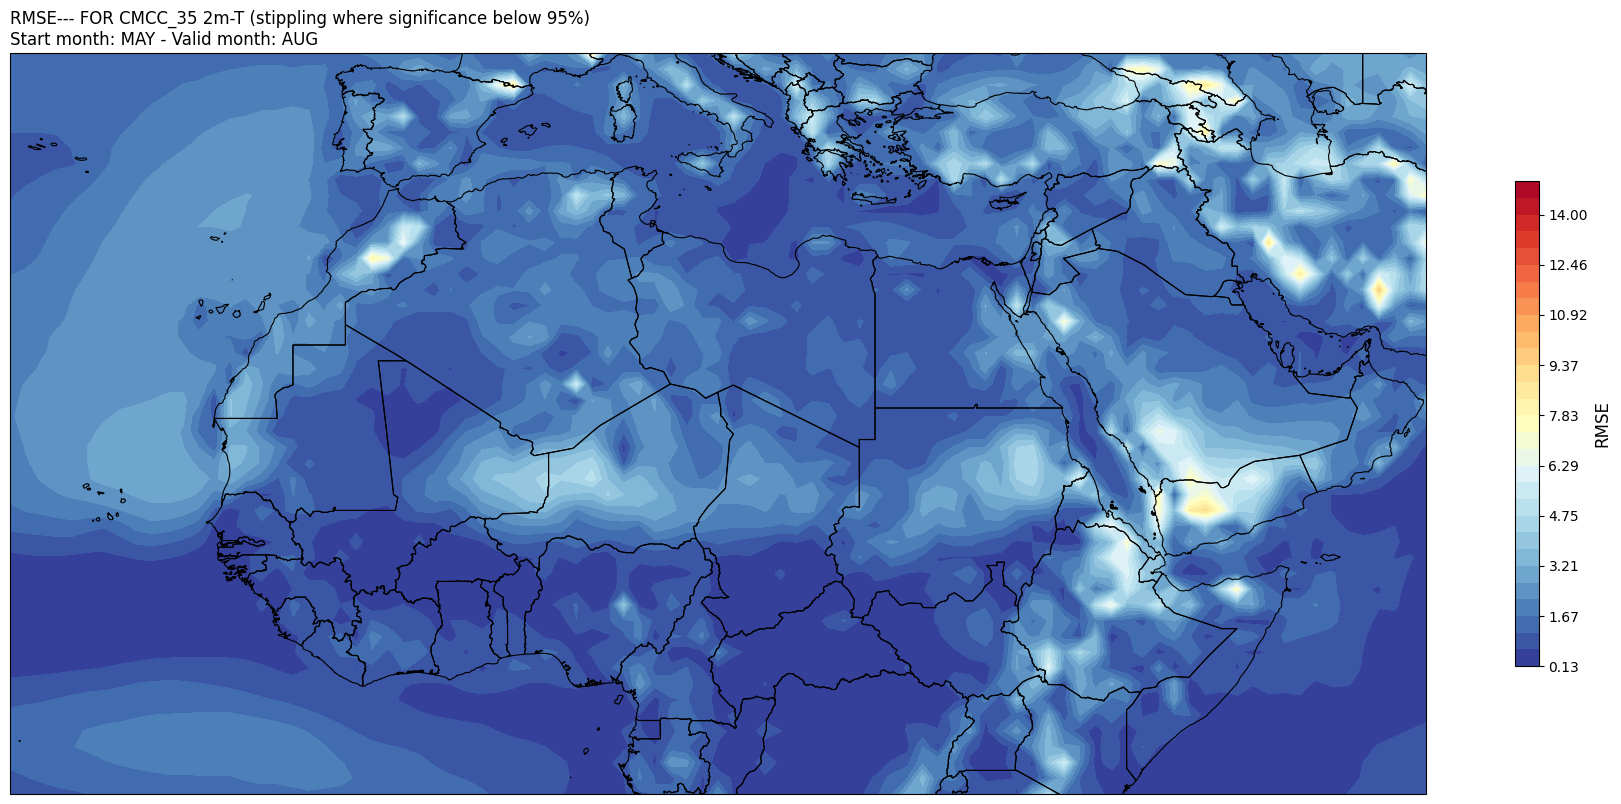

In [17]:
file_dropdown = widgets.Dropdown(



    options=available_files,



    description='CENTER'

)





def load_data(file_name, aggr, metric,period):

# Get the corresponding month

    mois = period_to_month.get(period)

    file_link = f'{SCOREDIR}/{file_name}_1993-2016_monthly_mean_{mois}_234_45_-30_-2.5_60_{period}.{aggr}.{metric}.nc'

    corr = xr.open_dataset(file_link)

    corr = corr.assign_coords(lon=(((corr.lon + 180) % 360) - 180)).sortby('lon')

    return corr



# Define the plot function



metrics=["corr","rsquared","rmse","corr_pval"]









def plot_corr(file_name, aggr, fcmonth,metric,period):



    config = dict(



    list_vars = ['2m_temperature', ],



    hcstarty = 1993,



    hcendy = 2016,



    start_month = period_to_month.get(period),



    )



    origin_labels = {'institution': f'{file_name}'



                     ,'metric':f'{metric}'}



    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data(file_name, aggr, metric, period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))



    



    METR = load_data(file_name, aggr,metric,period)



    tit_line1='{metric}---'.format(**origin_labels).upper()+" FOR "+file_name.upper()        



    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'



    if aggr == '1m':



        validmonth = config['start_month'] + (fcmonth - 1)



        validmonth = validmonth if validmonth <= 12 else validmonth - 12



        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'



    elif aggr == '3m':



        validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]



        tit_line2 = tit_line2_base + f' - Valid months: {period.upper()}'



    else:



        raise ValueError(f'Unexpected aggregation {aggr}')







    # Select data for the chosen forecast month



    THISMETR = METR.sel(forecastMonth=fcmonth)







    for var in THISMETR.data_vars:



        fig = plt.figure(figsize=(18, 10))



        ax = plt.axes(projection=ccrs.PlateCarree())









        METRVALUES = THISMETR[var].values







        if METRVALUES.T.shape == (THISMETR[var].lat.size, THISMETR[var].lon.size):



            METRVALUES = METRVALUES.T







        plt.contourf(



            THISMETR[var].lon, THISMETR[var].lat, METRVALUES,



            levels=np.linspace(global_min, global_max, 30),



            cmap='RdYlBu_r'



        )



        cb = plt.colorbar(shrink=0.5)



        cb.ax.set_ylabel(metric.upper(), fontsize=12)

        ax.set_extent([np.nanmin(THISMETR[var].lon), np.nanmax(THISMETR[var].lon), np.nanmin(THISMETR[var].lat), np.nanmax(THISMETR[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region



        shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)



        origylim = ax.get_ylim()



        if ax.get_ylim() != origylim:



            ax.set_ylim(origylim)







        plt.title(f"{tit_line1} {VARNAMES[var]} (stippling where significance below 95%)\n{tit_line2}", loc='left')



        plt.tight_layout()

        

        # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/{metric}/{metric}_UNIQUE_{file_name}_{period}.png")



        plt.show()







# Create interactive widgets for `aggr`, `fcmonth`, and file selection



aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')



fcmonth_slider = widgets.IntSlider(value=4, min=2, max=4, step=1, description='Forecast Month:')



metric_droptown=widgets.Dropdown(options=metrics,value="rmse",description="Metric")



# Display the interactive plot



widgets.interactive(plot_corr,period=period_dropdown, metric=metric_droptown,file_name=file_dropdown, aggr=aggr_dropdown, fcmonth=fcmonth_slider)

In [18]:
# for file_name in available_files:

#         for metric in metrics:

#             for period in periods:

#                     plot_corr(file_name, "3m", 4,metric,period)  

# B-PROBABILISTIC

In [19]:
VARNAMES = {

    't2m' : '2m-T'

}

details="_1993-2016_monthly_mean_11_234_45_-30_-2.5_60"



available_files=["ukmo_602","meteo_france_8","ecmwf_51","eccc_3","eccc_2","dwd_21","cmcc_35"]



CATNAMES=['lower tercile', 'middle tercile', 'upper tercile']



# Change titles font size

plt.rc('axes', titlesize=20)

## B-1 RPS

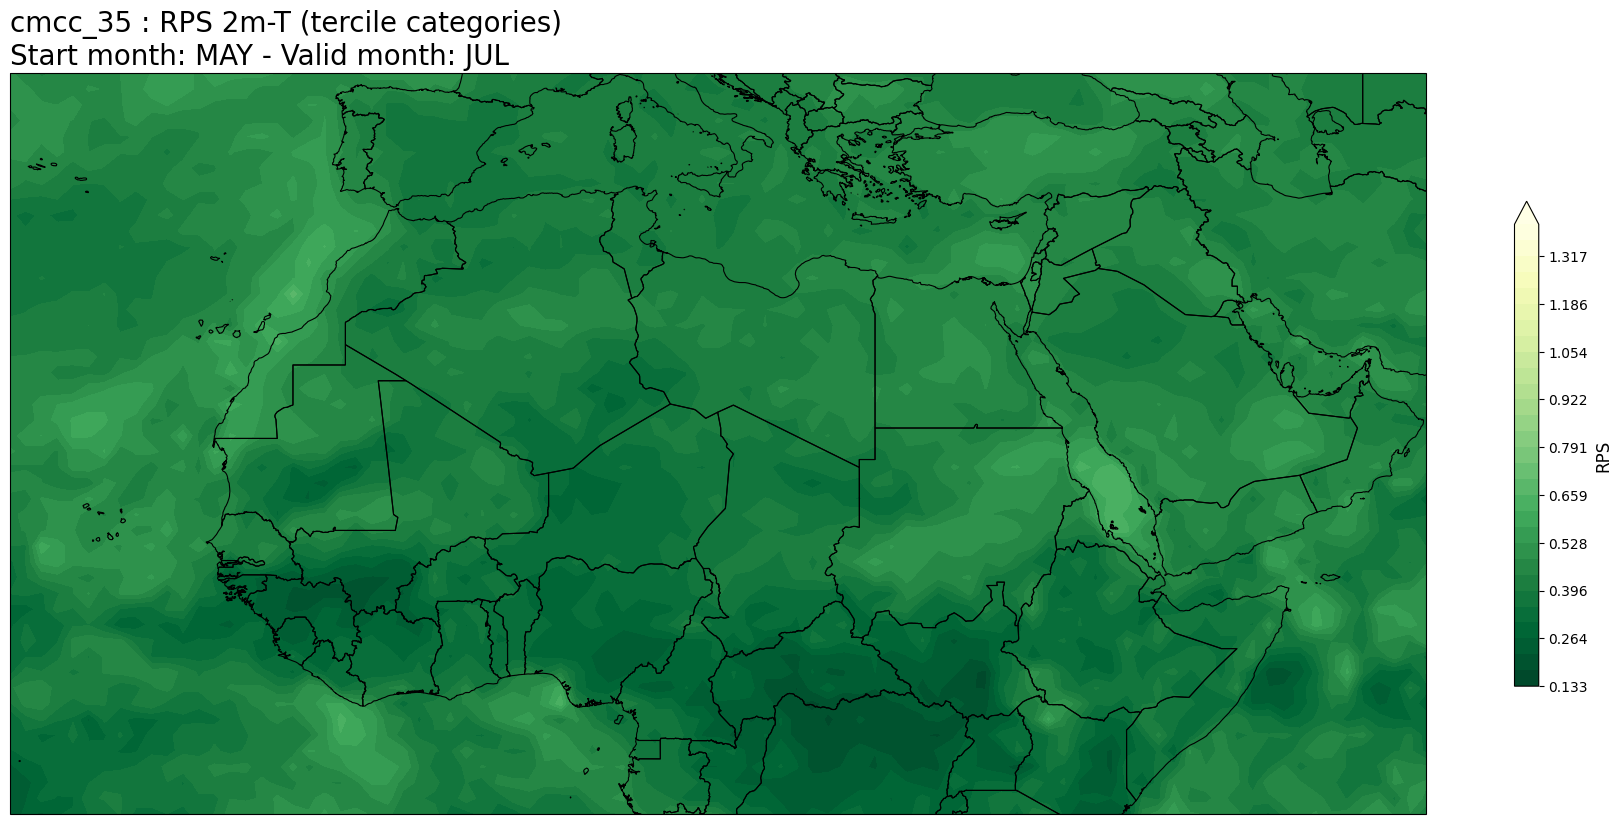

In [20]:
def load_data_proba(file, aggr, metric, period):

    period_to_month = {

        "djf": 11,

        "mam": 2,

        "jja": 5,

        "son": 8

    }



    mois = period_to_month.get(period)



    file_link = f'{SCOREDIR}/{file}_1993-2016_monthly_mean_{mois}_234_45_-30_-2.5_60_{period}.{aggr}.{metric}.nc'

    rps = xr.open_dataset(file_link)

    return rps





# Define the plot function

def plot_corr(file, aggr, fcmonth, period):

    period_to_month = {

        "djf": 11,

        "mam": 2,

        "jja": 5,

        "son": 8

    }



    config = dict(

        list_vars = ['2m_temperature'],

        hcstarty = 1993,

        hcendy = 2016,

        start_month = period_to_month.get(period),

    )



    origin_labels = {'institution': f'{file}', 'SCORE': "RPS"}





    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data(file_name, aggr, "rps", period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))



    tit_line1 = '{institution} : {SCORE}'.format(**origin_labels)

    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'



    if aggr == '1m':

        validmonth = config['start_month'] + (fcmonth - 1)

        validmonth = validmonth if validmonth <= 12 else validmonth - 12

        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

    elif aggr == '3m':

        validmonths = [vm if vm <= 12 else vm - 12 for vm in [config['start_month'] + (fcmonth - 1) - shift for shift in range(3)]]

        validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]

        tit_line2 = tit_line2_base + f' - Valid months: {period}'

    else:

        raise BaseException(f'Unexpected aggregation {aggr}')

    

    rps = load_data_proba(file, aggr, "rps", period)

    

    # Select data for the chosen forecast month

    thisrps = rps.sel(forecastMonth=fcmonth)

    for var in thisrps.data_vars:

        fig = plt.figure(figsize=(18, 10))

        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.set_extent([np.nanmin(thisrps[var].lon), np.nanmax(thisrps[var].lon), np.nanmin(thisrps[var].lat), np.nanmax(thisrps[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region

        avalues = thisrps[var].values

        cs = plt.contourf(thisrps[var].lon, thisrps[var].lat, avalues, levels=np.linspace(global_min, global_max, 30), cmap='YlGn_r', extend='max')

        cs.cmap.set_under('purple')

        cb = plt.colorbar(shrink=0.5)

        cb.ax.set_ylabel('RPS', fontsize=12)

        shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

        plt.title(tit_line1 + f' {VARNAMES[var]}' + ' (tercile categories)\n' + tit_line2, loc='left')

        plt.tight_layout()  

        # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/rps/rps_UNIQUE_{file_name}_{period}.png")

        plt.show()





# Create interactive widgets for `aggr` and `fcmonth`

aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')

fcmonth_slider = widgets.IntSlider(value=3, min=2, max=4, step=1, description='Forecast Month:')

file_droptown = widgets.Dropdown(options=available_files, value="cmcc_35", description="Center")

widgets.interactive(plot_corr, file=file_droptown, aggr=aggr_dropdown, fcmonth=fcmonth_slider, period=period_dropdown)


In [21]:
# for file_name in available_files:

#     for fcmonth in [2,3,4]:

#         for period in periods:

#             plot_corr(file_name, "3m", 4,period)  

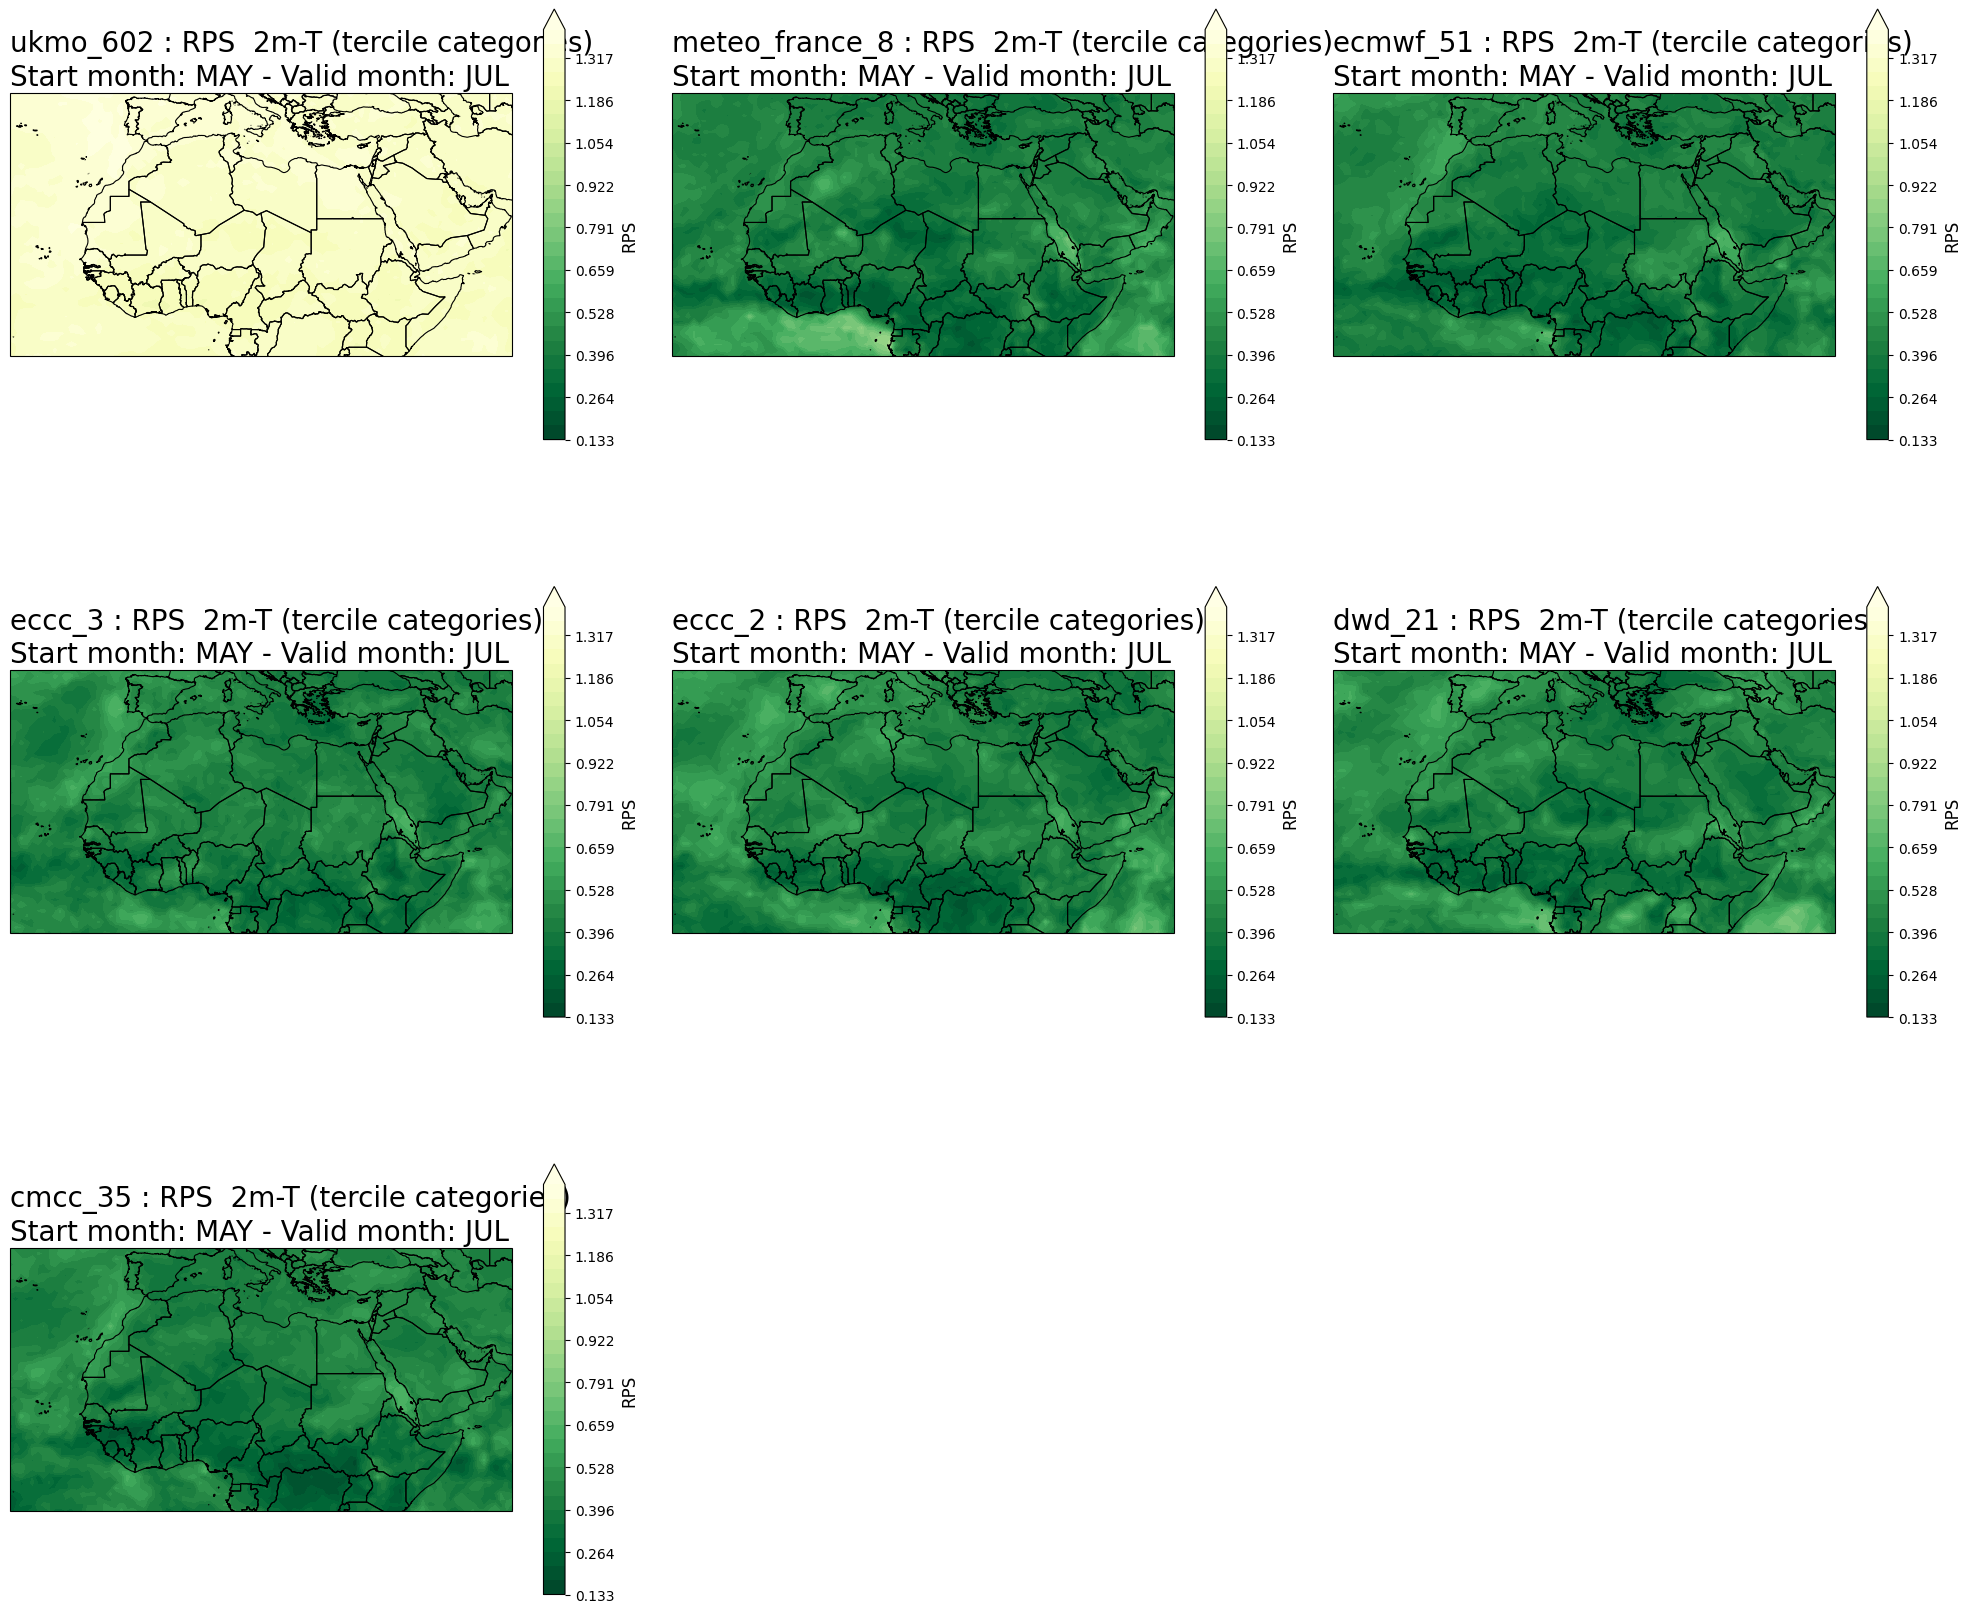

In [22]:
metric = "rps"



def load_data(file, aggr, metric, period):

    period_to_month = {

        "djf": 11,

        "mam": 2,

        "jja": 5,

        "son": 8

    }

    mois = period_to_month.get(period)

    file_link = f'{SCOREDIR}/{file}_1993-2016_monthly_mean_{mois}_234_45_-30_-2.5_60_{period}.{aggr}.{metric}.nc'

    rps = xr.open_dataset(file_link)

    return rps



# Define the plot function

def plot_rps(aggr, fcmonth, period):

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols



    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})

    axes = axes.flatten()



    config = dict(

        list_vars = ['2m_temperature'],

        hcstarty = 1993,

        hcendy = 2016,

        start_month = period_to_month.get(period),

    )

    

    for i, center in enumerate(available_files):

        rps = load_data(center, aggr, "rps", period)

        origin_labels = {'institution': f'{center}', 'SCORE':"RPS"}

        # Select data for the chosen forecast month

        thisrps = rps.sel(forecastMonth=fcmonth)





        global_min, global_max = float('inf'), float('-inf')

        for file_name in available_files:

            METR = load_data(file_name, aggr, metric, period)

            for var in METR.data_vars:

                global_min = min(global_min, np.nanmin(METR[var].values))

                global_max = max(global_max, np.nanmax(METR[var].values))



        tit_line1 = '{institution} : {SCORE} '.format(**origin_labels)

        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

    

        if aggr == '1m':

            validmonth = config['start_month'] + (fcmonth-1)

            validmonth = validmonth if validmonth <= 12 else validmonth - 12

            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

        elif aggr == '3m':

            validmonths = [vm if vm <= 12 else vm - 12 for vm in [config['start_month'] + (fcmonth - 1) - shift for shift in range(3)]]

            validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]

            tit_line2 = tit_line2_base + f' - Valid months: {period}'

        else:

            raise BaseException(f'Unexpected aggregation {aggr}')

        

        for var in thisrps.data_vars:

            ax = axes[i]

            ax.set_extent([np.nanmin(thisrps[var].lon), np.nanmax(thisrps[var].lon), np.nanmin(thisrps[var].lat), np.nanmax(thisrps[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region



            # Plot the data

            avalues = thisrps[var].values

            cs = ax.contourf(thisrps[var].lon, thisrps[var].lat, avalues, levels=np.linspace(global_min, global_max, 30), cmap='YlGn_r', extend='max')

            cs.cmap.set_under('purple')

            

            # Add a colorbar to each subplot

            cb = fig.colorbar(cs, ax=ax, shrink=0.7)

            cb.ax.set_ylabel('RPS', fontsize=12)

            

            # Set the title for each subplot

            ax.set_title(tit_line1 + f' {VARNAMES.get(var, var)}' + ' (tercile categories)\n' + tit_line2, loc='left')

            shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

    

    # Remove any unused subplots

    for j in range(i + 1, len(axes)):

        fig.delaxes(axes[j])

    

    plt.tight_layout()

    # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/rps/rps_{period}.png")

    plt.show()



# Create interactive widgets for `aggr` and `fcmonth`

aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')

fcmonth_slider = widgets.IntSlider(value=3, min=2, max=4, step=1, description='Forecast Month:')

widgets.interactive(plot_rps, aggr=aggr_dropdown, fcmonth=fcmonth_slider, period=period_dropdown)


In [23]:
# for period in periods :

#     plot_rps("3m",4,period)  

## B-2 ROC-ROCSS-BS

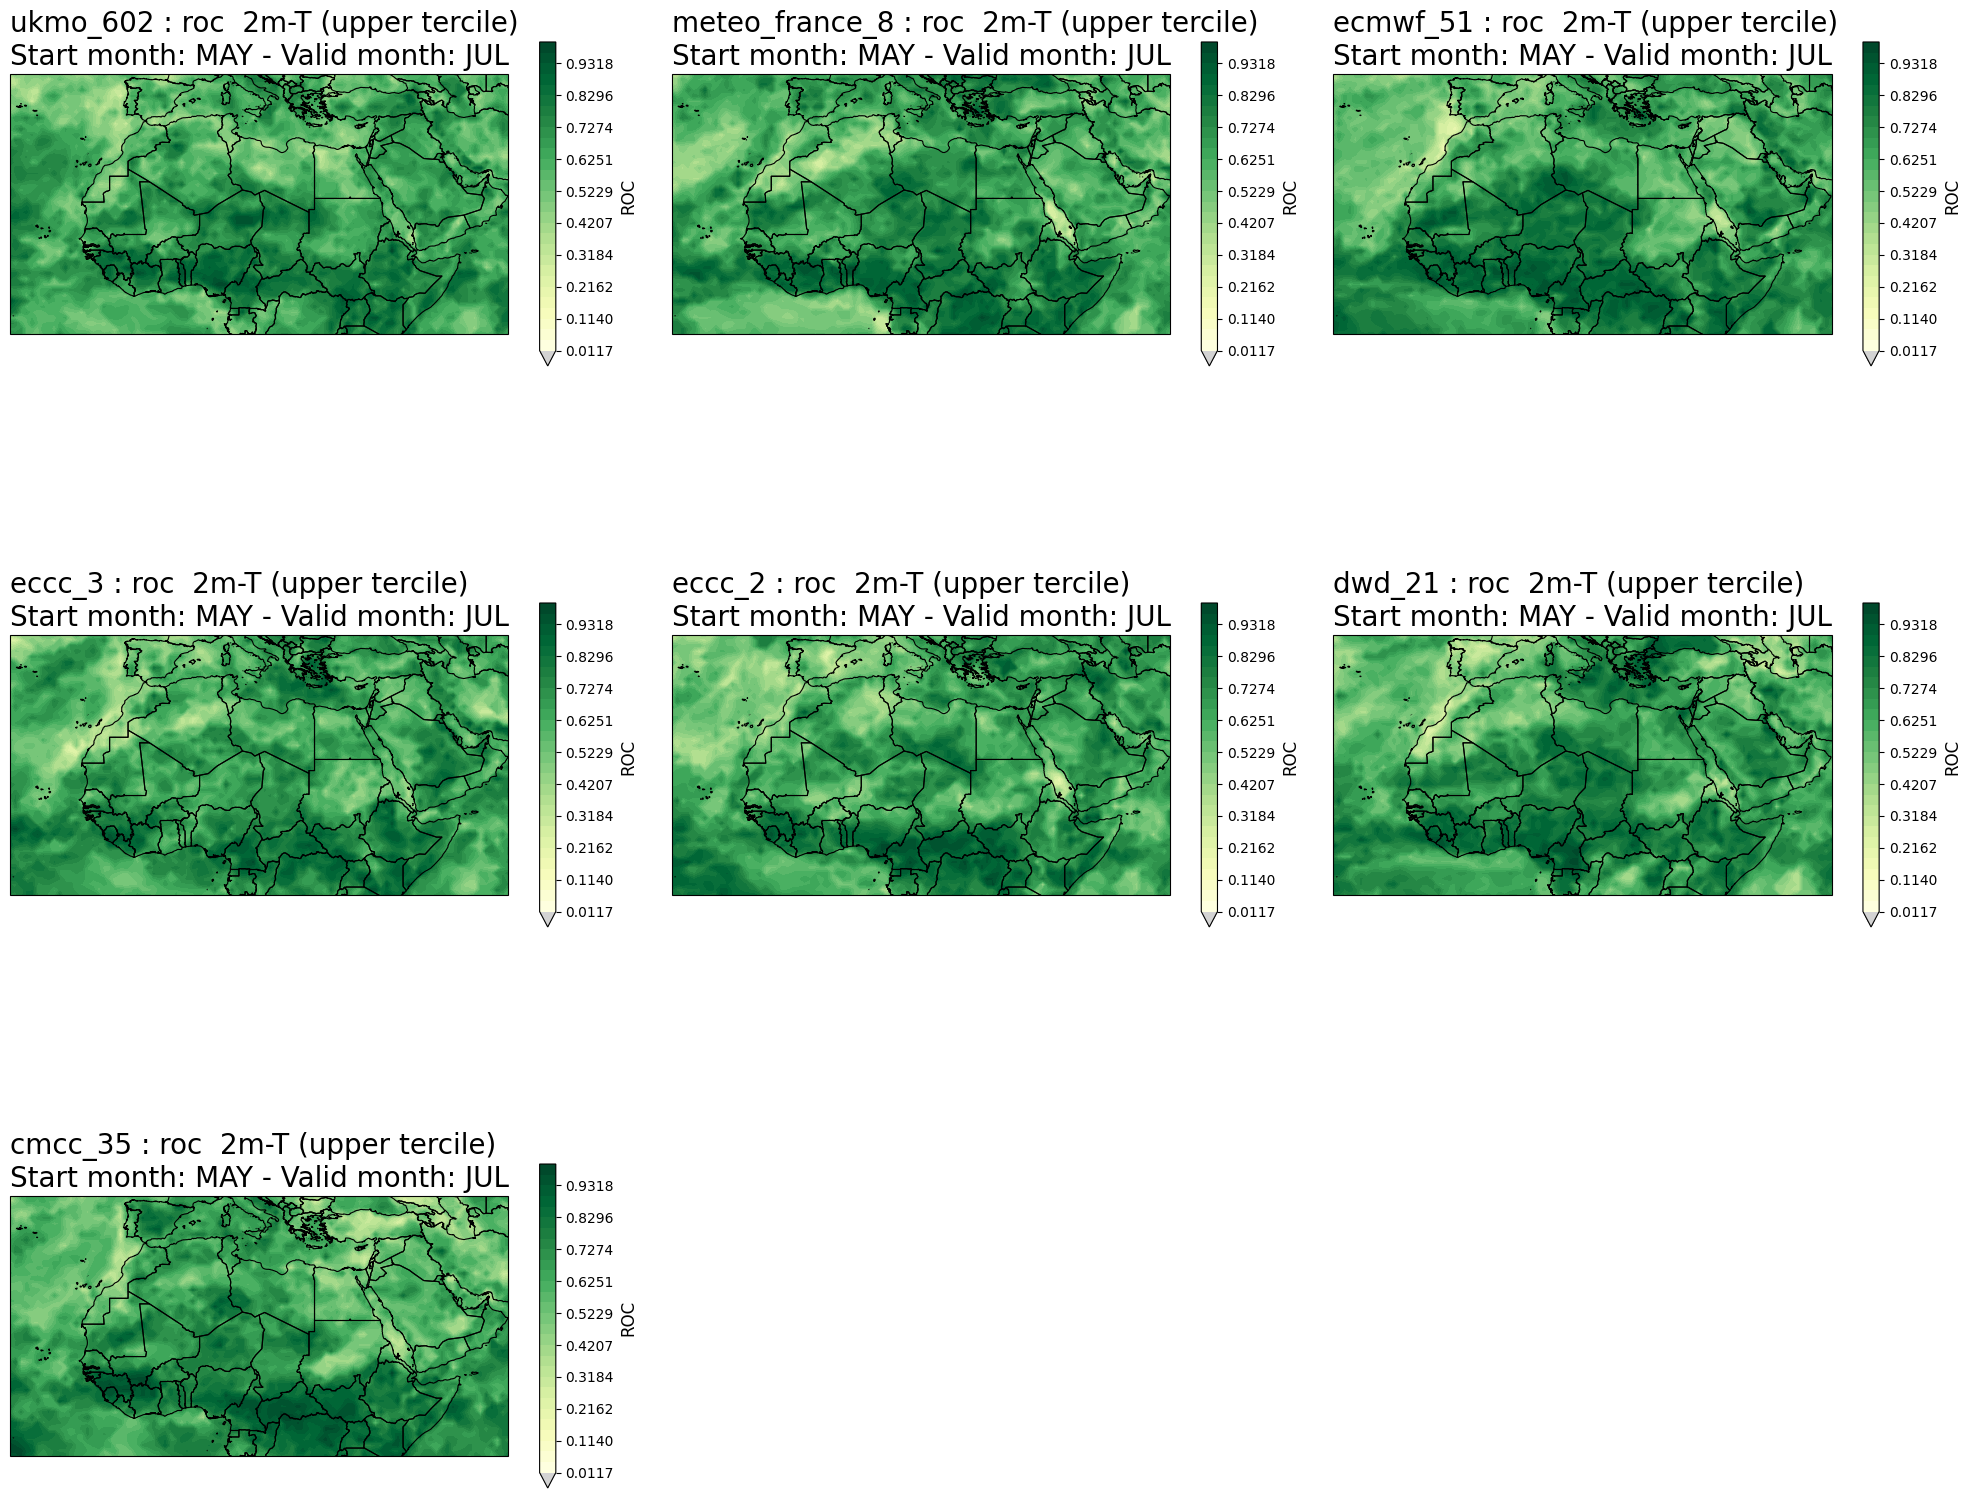

In [24]:
category=["lower","middle","upper"]

def plot_roc(aggr, fcmonth, icat, metric,period):

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols 



    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})

    axes = axes.flatten()



    config = dict(



    list_vars = ['2m_temperature', ],



    hcstarty = 1993,



    hcendy = 2016,



    start_month = period_to_month.get(period),



    )





    for i in range(n_files):

        origin_labels = {'institution': f'{available_files[i]}', 'SCORE': metric}

        tit_line1 = '{institution} : {SCORE} '.format(**origin_labels)

        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

        

        if aggr == '1m':

            validmonth = config['start_month'] + (fcmonth - 1)

            validmonth = validmonth if validmonth <= 12 else validmonth - 12

            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

        elif aggr == '3m':

            validmonths = [vm if vm <= 12 else vm - 12 for vm in [config['start_month'] + (fcmonth - 1) - shift for shift in range(3)]]

            validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]

            tit_line2 = tit_line2_base + f' - Valid months: {period}'

        else:

            raise BaseException(f'Unexpected aggregation {aggr}')





        global_min, global_max = float('inf'), float('-inf')

        for file_name in available_files:

            METR = load_data(file_name, aggr, metric, period)

            for var in METR.data_vars:

                global_min = min(global_min, np.nanmin(METR[var].values))

                global_max = max(global_max, np.nanmax(METR[var].values))

        

        roc = load_data_proba(available_files[i], aggr, metric,period)

        thisroc = roc.sel(forecastMonth=fcmonth)



        for var in thisroc.data_vars:





            avalues = thisroc.sel(category=icat)[var].values



            if not np.isnan(avalues).all():

                cs = axes[i].contourf(

                    thisroc[var].lon,

                    thisroc[var].lat,

                    avalues,

                    levels=np.linspace(global_min, global_max, 30),

                    cmap='YlGn', 

                    extend='min'

                )

                cs.cmap.set_under('lightgray')

                cb = fig.colorbar(cs, ax=axes[i], shrink=0.5)

                cb.ax.set_ylabel(metric.upper(), fontsize=12)

            axes[i].set_extent([np.nanmin(thisroc[var].lon), np.nanmax(thisroc[var].lon), np.nanmin(thisroc[var].lat), np.nanmax(thisroc[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region





            shp.plot(ax=axes[i], edgecolor='black', facecolor='none', linewidth=0.8)

            axes[i].set_title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[icat]})\n' + tit_line2, loc='left')



    for j in range(n_files, len(axes)):

        fig.delaxes(axes[j])



    plt.tight_layout()

    # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/{metric}/{metric}_{period}_{category[icat]}.png")

    plt.show()



cat_slider = widgets.IntSlider(value=3, min=0, max=2, step=1, description="cat")

fcmonth_slider = widgets.IntSlider(value=3, min=2, max=4, step=1, description="fcmonth")

aggr_dropdown = widgets.Dropdown(options=["1m", "3m"], value="1m", description="aggr")

metric_dropdown = widgets.Dropdown(options=["roc", "rocss", "bs"], value="roc", description="Metric")

widgets.interactive(plot_roc, period=period_dropdown,metric=metric_dropdown, aggr=aggr_dropdown, fcmonth=fcmonth_slider, icat=cat_slider)

In [25]:
# metrics=["roc", "rocss", "bs"]

# for metric in metrics:

#     for period in periods :

#         for icat in [0,1,2]:

#             plot_roc("3m", 4,icat,metric,period)  


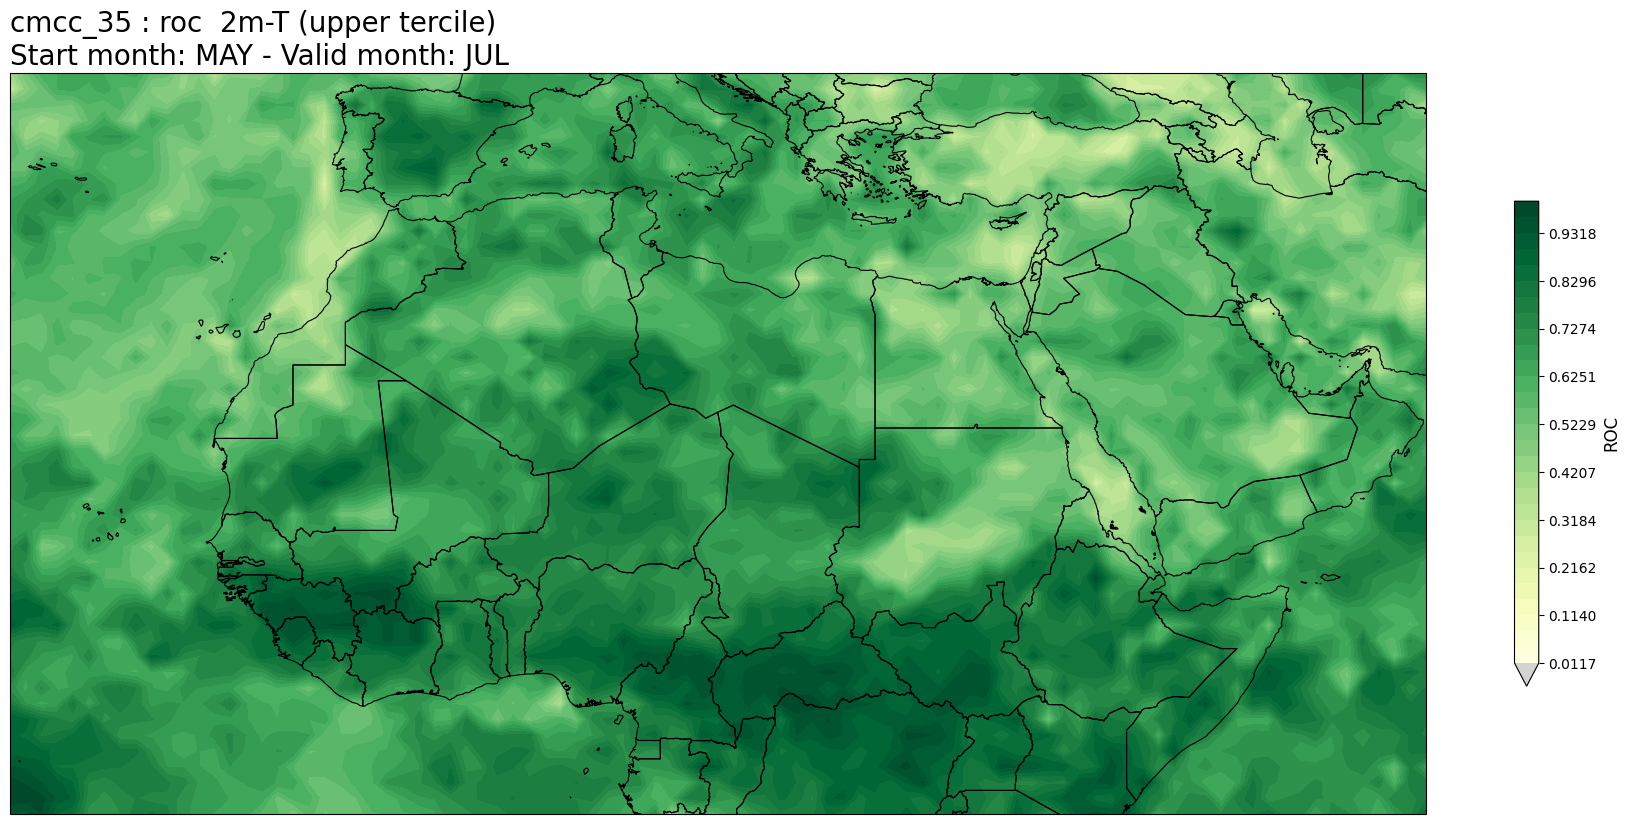

In [26]:
def plot_roc(file,aggr,fcmonth,icat,metric,period):



    config = dict(



    list_vars = ['2m_temperature', ],



    hcstarty = 1993,



    hcendy = 2016,



    start_month = period_to_month.get(period),



    )



    origin_labels = {'institution': f'{file}',

                    'SCORE':metric}

    

    tit_line1 = '{institution} : {SCORE} '.format(**origin_labels)

    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data_proba(file_name, aggr, metric, period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))

    

    

    

    if aggr=='1m':

        validmonth = config['start_month'] + (fcmonth-1)

        validmonth = validmonth if validmonth<=12 else validmonth-12

    #     tit_line2 = tit_line2_base + rf' - Valid month: $\bf{calendar.month_abbr[validmonth].upper()}$'

        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

    elif aggr=='3m':

        validmonths = [vm if vm<=12 else vm-12 for vm in [config['start_month'] + (fcmonth-1) - shift for shift in range(3)]]

        validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]

    #     tit_line2 = tit_line2_base + rf' - Valid months: $\bf{"".join(validmonths)}$'

        tit_line2 = tit_line2_base + f' - Valid months: {period}'

    else:

        raise BaseException(f'Unexpected aggregation {aggr}')

    

    roc=load_data_proba(file,aggr,metric,period)

    thisroc = roc.sel(forecastMonth=fcmonth)

    for var in thisroc.data_vars:

        fig = plt.figure(figsize=(18,10))

        ax = plt.axes(projection=ccrs.PlateCarree())

        avalues = thisroc.sel(category=icat)[var].values

        cs = plt.contourf(thisroc[var].lon,thisroc[var].lat,avalues,levels=np.linspace(global_min, global_max, 30),cmap='YlGn', extend='min')

        cs.cmap.set_under('lightgray')

        cb = plt.colorbar(shrink=0.5)

        cb.ax.set_ylabel(metric.upper(),fontsize=12)

        ax.set_extent([np.nanmin(thisroc[var].lon), np.nanmax(thisroc[var].lon), np.nanmin(thisroc[var].lat), np.nanmax(thisroc[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region

        shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

        plt.title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[icat]})\n' + tit_line2, loc='left')

        plt.tight_layout()  

        # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/{metric}/{metric}_unique_{period}.png")

        plt.show()



file_droptown=widgets.Dropdown(options=available_files,value="cmcc_35",description="Center")

cat_slider=widgets.IntSlider(value=3,min=0,max=2,step=1,description="cat")

fcmonth_slider=widgets.IntSlider(value=3,min=2,max=4,step=1,description="fcmonth")

aggr_droptown=widgets.Dropdown(options=["1m","3m"],value="1m",description="aggr")

metric_dropdown=widgets.Dropdown(options=["roc","rocss","bs"],value="roc",description="Metric")

widgets.interactive(plot_roc,period=period_dropdown,metric=metric_dropdown,file=file_droptown,aggr=aggr_droptown,fcmonth=fcmonth_slider,icat=cat_slider)

## B-2 RELIABILITY

Shape of avalues: t2m
Shape of avalues: t2m
Shape of avalues: t2m
Shape of avalues: t2m
Shape of avalues: t2m
Shape of avalues: t2m
Shape of avalues: t2m


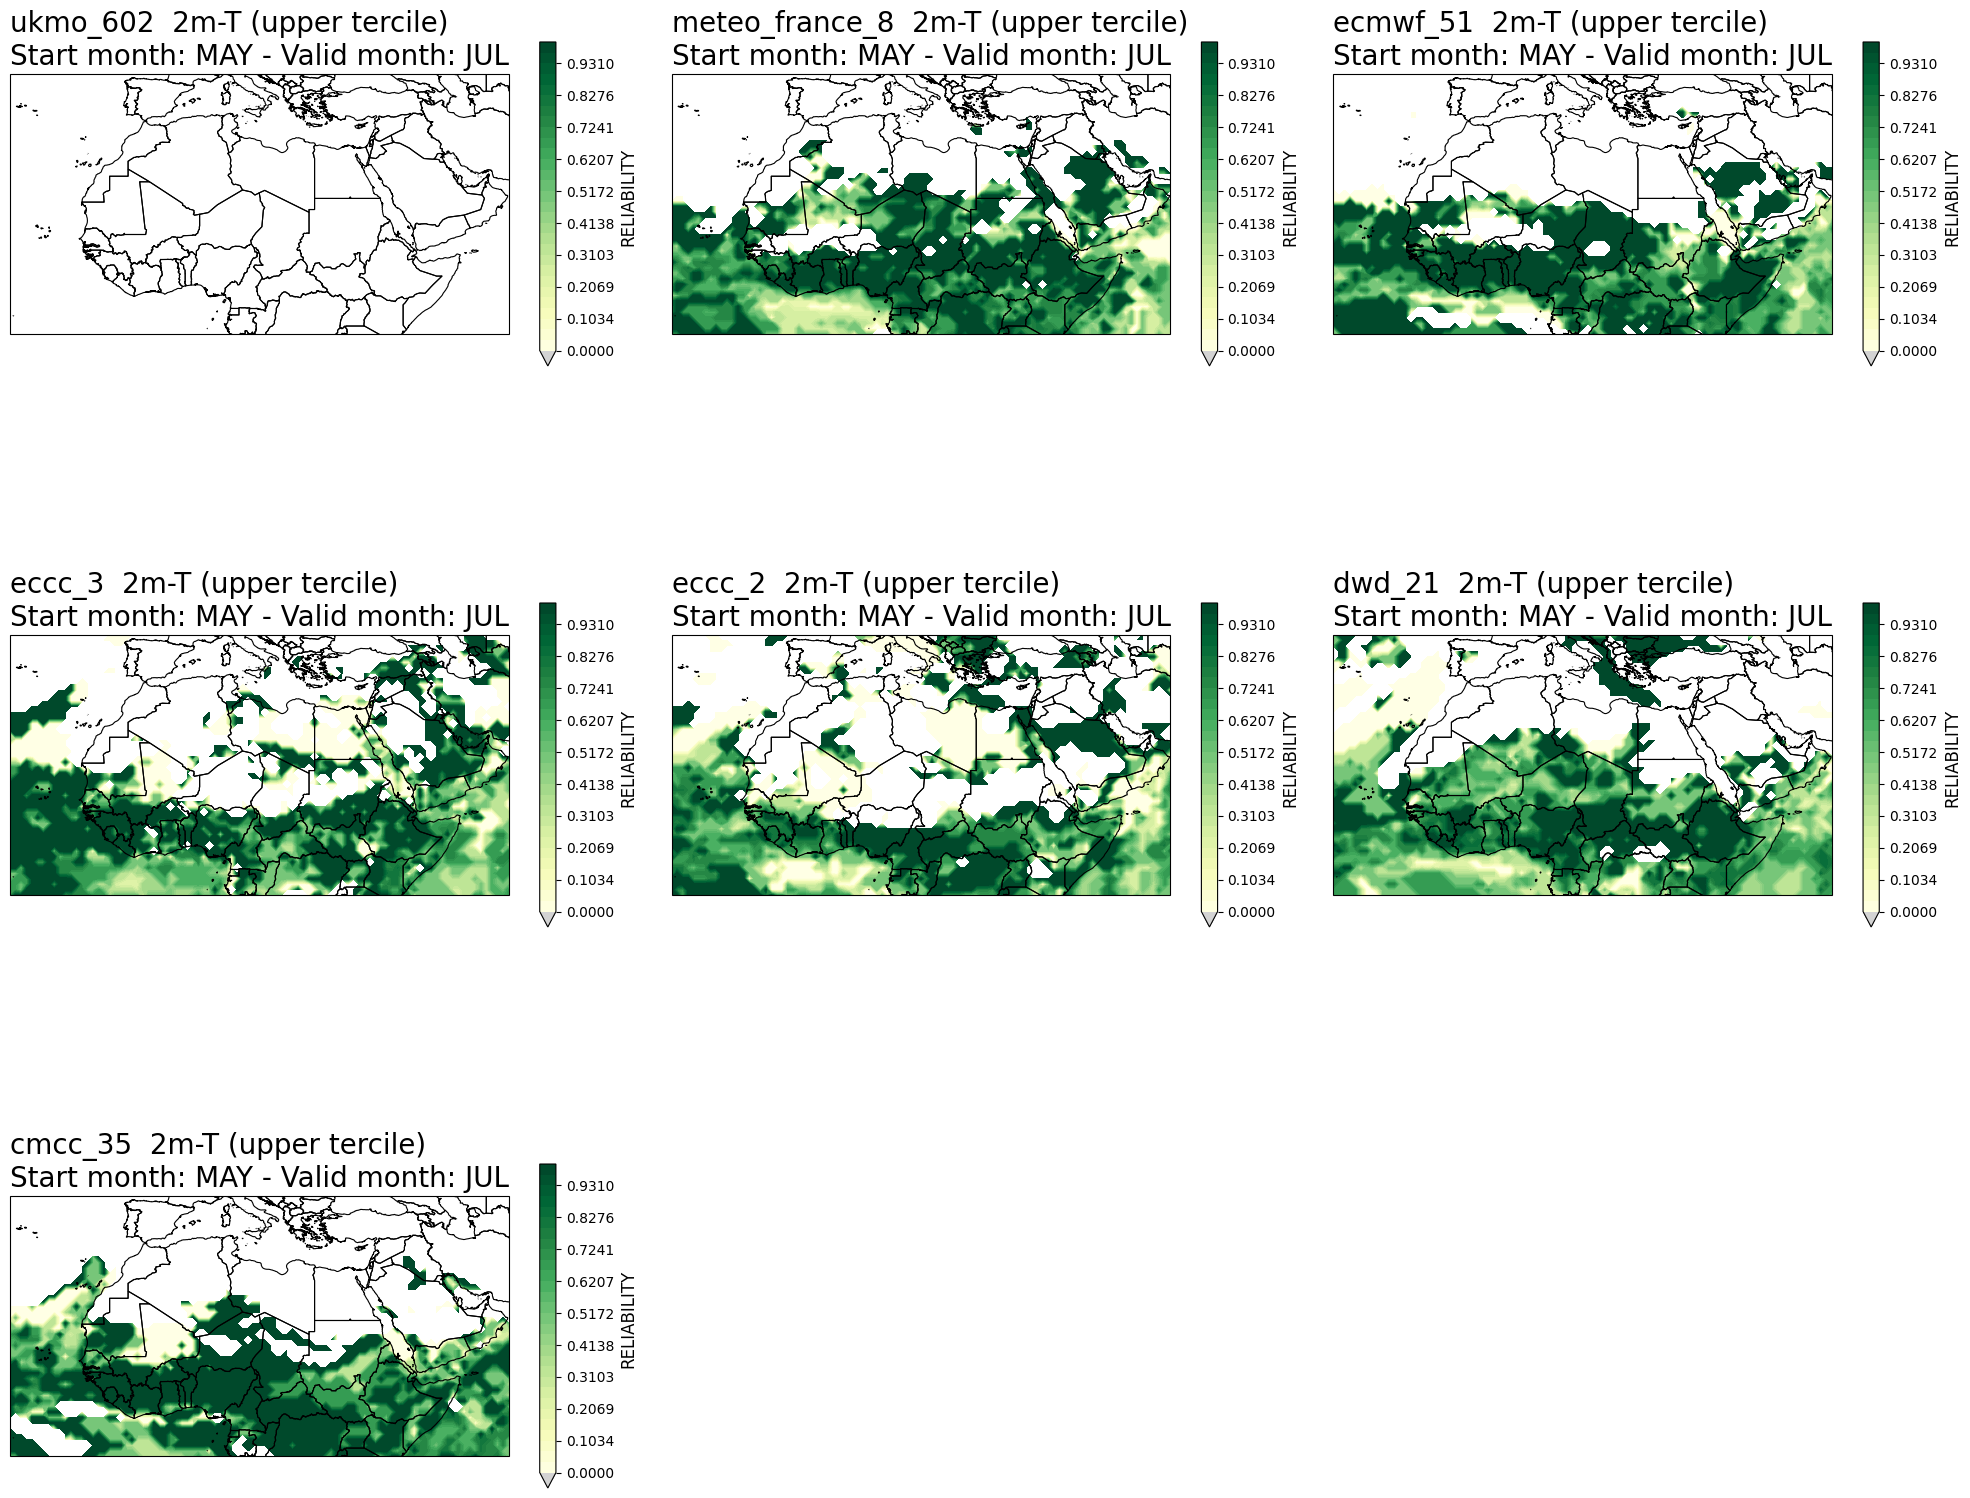

In [27]:
# READ scores xr.Datasets

import calendar



import ipywidgets as widgets





def plot_rela(aggr,fcmonth,cat,forcast_probability,period):







    config = dict(



    list_vars = ['2m_temperature', ],



    hcstarty = 1993,



    hcendy = 2016,



    start_month = period_to_month.get(period),



    )

    metric="rela"





    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data_proba(file_name, aggr, metric, period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))



    

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols 



    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), subplot_kw={'projection': ccrs.PlateCarree()})

    axes = axes.flatten()



    for i in range(len(available_files)):



        center=available_files[i]



        # rela = xr.open_dataset(f'{SCOREDIR}/{center}{details}.{aggr}.rela.nc')

        metric="rela"

        rela=load_data_proba(available_files[i], aggr, metric,period)

    

        thisrela = rela.sel(forecastMonth=fcmonth)

    

        origin_labels={"institution" : center}

        

        tit_line1 = '{institution} '.format(**origin_labels)

    

        tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

    

        if aggr == '1m':

    

            validmonth = config['start_month'] + (fcmonth - 1)

    

            validmonth = validmonth if validmonth <= 12 else validmonth - 12

    

            tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'

    

        elif aggr == '3m':

    

            validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]

    

            tit_line2 = tit_line2_base + f' - Valid months: {period}'

    

        else:

    

            raise ValueError(f'Unexpected aggregation {aggr}')

            

        # print(thisrela.t2m.forecast_probability)

        # print(thisrela.data_vars)

        for var in thisrela.data_vars:

    

            avalues = thisrela.sel(category=cat,forecast_probability=forcast_probability,method='nearest')[var].values

    

            print("Shape of avalues:", var)

    

            # cs = plt.contourf(thisrela[var].lon,thisrela[var].lat,avalues,levels=np.linspace(0.5,1.,6),cmap='YlGn', extend='min')

            cs = axes[i].contourf(thisrela[var].lon,thisrela[var].lat,avalues,levels=np.linspace(global_min, global_max, 30),cmap='YlGn', extend='min')

    

            cs.cmap.set_under('lightgray')

    

            cb = fig.colorbar(cs,ax=axes[i],shrink=0.5)

    

            cb.ax.set_ylabel('RELIABILITY',fontsize=12)

            axes[i].set_extent([np.nanmin(thisrela[var].lon), np.nanmax(thisrela[var].lon), np.nanmin(thisrela[var].lat), np.nanmax(thisrela[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region





            shp.plot(ax=axes[i], edgecolor='black', facecolor='none', linewidth=0.8)

    

            axes[i].set_title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[cat]})\n' + tit_line2, loc='left')

    



    for j in range(n_files, len(axes)):

        fig.delaxes(axes[j])



    plt.tight_layout()

    # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/{metric}/{metric}_{period}.png")

    plt.show()







cat_slider=widgets.IntSlider(value=3,min=0,max=2,step=1,description="cat")



forcast_probability_slider=widgets.FloatSlider(value=10,min=0.1,max=0.9,step=0.2,description="forcast probability")



fcmonth_slider=widgets.IntSlider(value=3,min=2,max=4,step=1,description="fcmonth")



aggr_droptown=widgets.Dropdown(options=["1m","3m"],value="1m",description="aggr")



# file_droptown=widgets.Dropdown(options=available_files,value="cmcc_35",description="Center")



widgets.interactive(plot_rela,period=period_dropdown,aggr=aggr_droptown,fcmonth=fcmonth_slider,cat=cat_slider,forcast_probability=forcast_probability_slider)

Shape of avalues: t2m


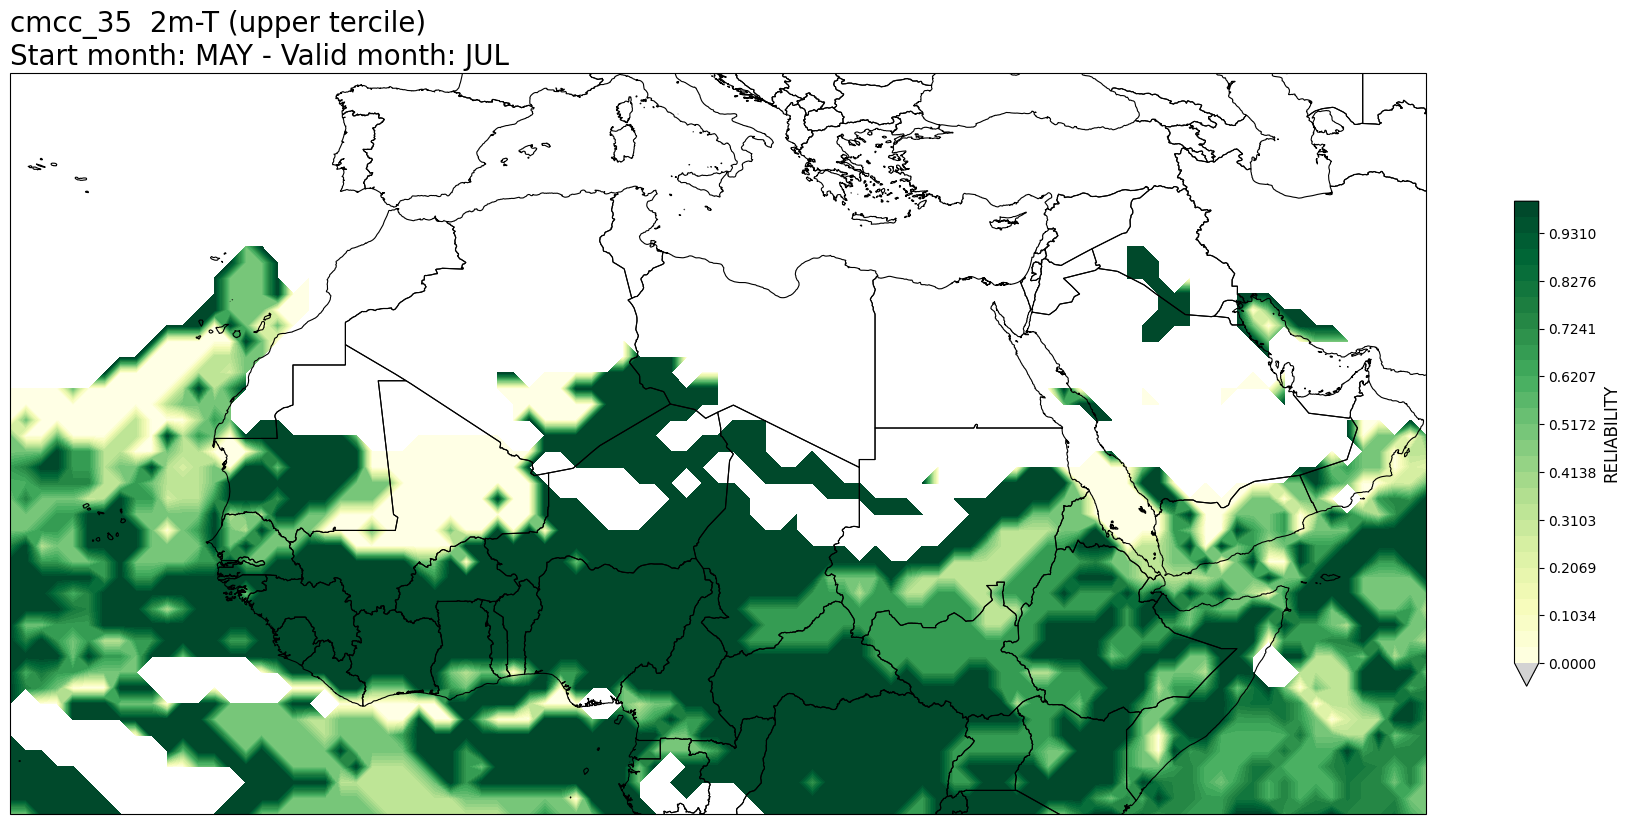

In [28]:
# READ scores xr.Datasets

import calendar



import ipywidgets as widgets



# def load_data_proba(file,aggr,metric,period):

#     period_to_month = {

#     "djf": 11,

#     "mam": 2,

#     "jja": 5,

#     "son": 8

#     }



#     mois = period_to_month.get(period)



#     file_link = f'{SCOREDIR}/{file}_1993-2016_monthly_mean_{mois}_234_45_-30_-2.5_60_{period}.{aggr}.{metric}.nc'

#     rps = xr.open_dataset(file_link)

#     return rps



def plot_rela(center,aggr,fcmonth,cat,forcast_probability,period):



    config = dict(



    list_vars = ['2m_temperature', ],



    hcstarty = 1993,



    hcendy = 2016,



    start_month = period_to_month.get(period),



    )



    # rela = xr.open_dataset(f'{SCOREDIR}/{center}{details}.{aggr}.rela.nc')

    metric="rela"

    global_min, global_max = float('inf'), float('-inf')

    for file_name in available_files:

        METR = load_data_proba(file_name, aggr, metric, period)

        for var in METR.data_vars:

            global_min = min(global_min, np.nanmin(METR[var].values))

            global_max = max(global_max, np.nanmax(METR[var].values))

    

    rela=load_data_proba(center, aggr, metric,period)



    thisrela = rela.sel(forecastMonth=fcmonth)



    origin_labels={"institution" : center}

    

    tit_line1 = '{institution} '.format(**origin_labels)



    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'



    if aggr == '1m':



        validmonth = config['start_month'] + (fcmonth - 1)



        validmonth = validmonth if validmonth <= 12 else validmonth - 12



        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'



    elif aggr == '3m':



        validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]



        tit_line2 = tit_line2_base + f' - Valid months: {period}'



    else:



        raise ValueError(f'Unexpected aggregation {aggr}')

        

    # print(thisrela.t2m.forecast_probability)

    # print(thisrela.data_vars)

    for var in thisrela.data_vars:



        fig = plt.figure(figsize=(18,10))



        ax = plt.axes(projection=ccrs.PlateCarree())



        avalues = thisrela.sel(category=cat,forecast_probability=forcast_probability,method='nearest')[var].values



        print("Shape of avalues:", var)



        # cs = plt.contourf(thisrela[var].lon,thisrela[var].lat,avalues,levels=np.linspace(0.5,1.,6),cmap='YlGn', extend='min')

        cs = plt.contourf(thisrela[var].lon,thisrela[var].lat,avalues,levels=np.linspace(global_min, global_max, 30),cmap='YlGn', extend='min')



        cs.cmap.set_under('lightgray')



        cb = plt.colorbar(shrink=0.5)



        cb.ax.set_ylabel('RELIABILITY',fontsize=12)





        plt.title(tit_line1 + f' {VARNAMES[var]}' + f' ({CATNAMES[cat]})\n' + tit_line2, loc='left')

        shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.8)

        ax.set_extent([np.nanmin(thisrela[var].lon), np.nanmax(thisrela[var].lon), np.nanmin(thisrela[var].lat), np.nanmax(thisrela[var].lat)], crs=ccrs.PlateCarree())  # Adjust extent for Morocco region



        plt.tight_layout()  

        # plt.savefig(f"/home/mohamed/EHTPIII/MODELISATION/output/plots/rela/rela_unique_{period}.png")



        plt.show()



cat_slider=widgets.IntSlider(value=3,min=0,max=2,step=1,description="cat")



forcast_probability_slider=widgets.FloatSlider(value=10,min=0.1,max=0.9,step=0.2,description="forcast probability")



fcmonth_slider=widgets.IntSlider(value=3,min=2,max=4,step=1,description="fcmonth")



aggr_droptown=widgets.Dropdown(options=["1m","3m"],value="1m",description="aggr")



file_droptown=widgets.Dropdown(options=available_files,value="cmcc_35",description="Center")



widgets.interactive(plot_rela,period=period_dropdown,center=file_droptown,aggr=aggr_droptown,fcmonth=fcmonth_slider,cat=cat_slider,forcast_probability=forcast_probability_slider)

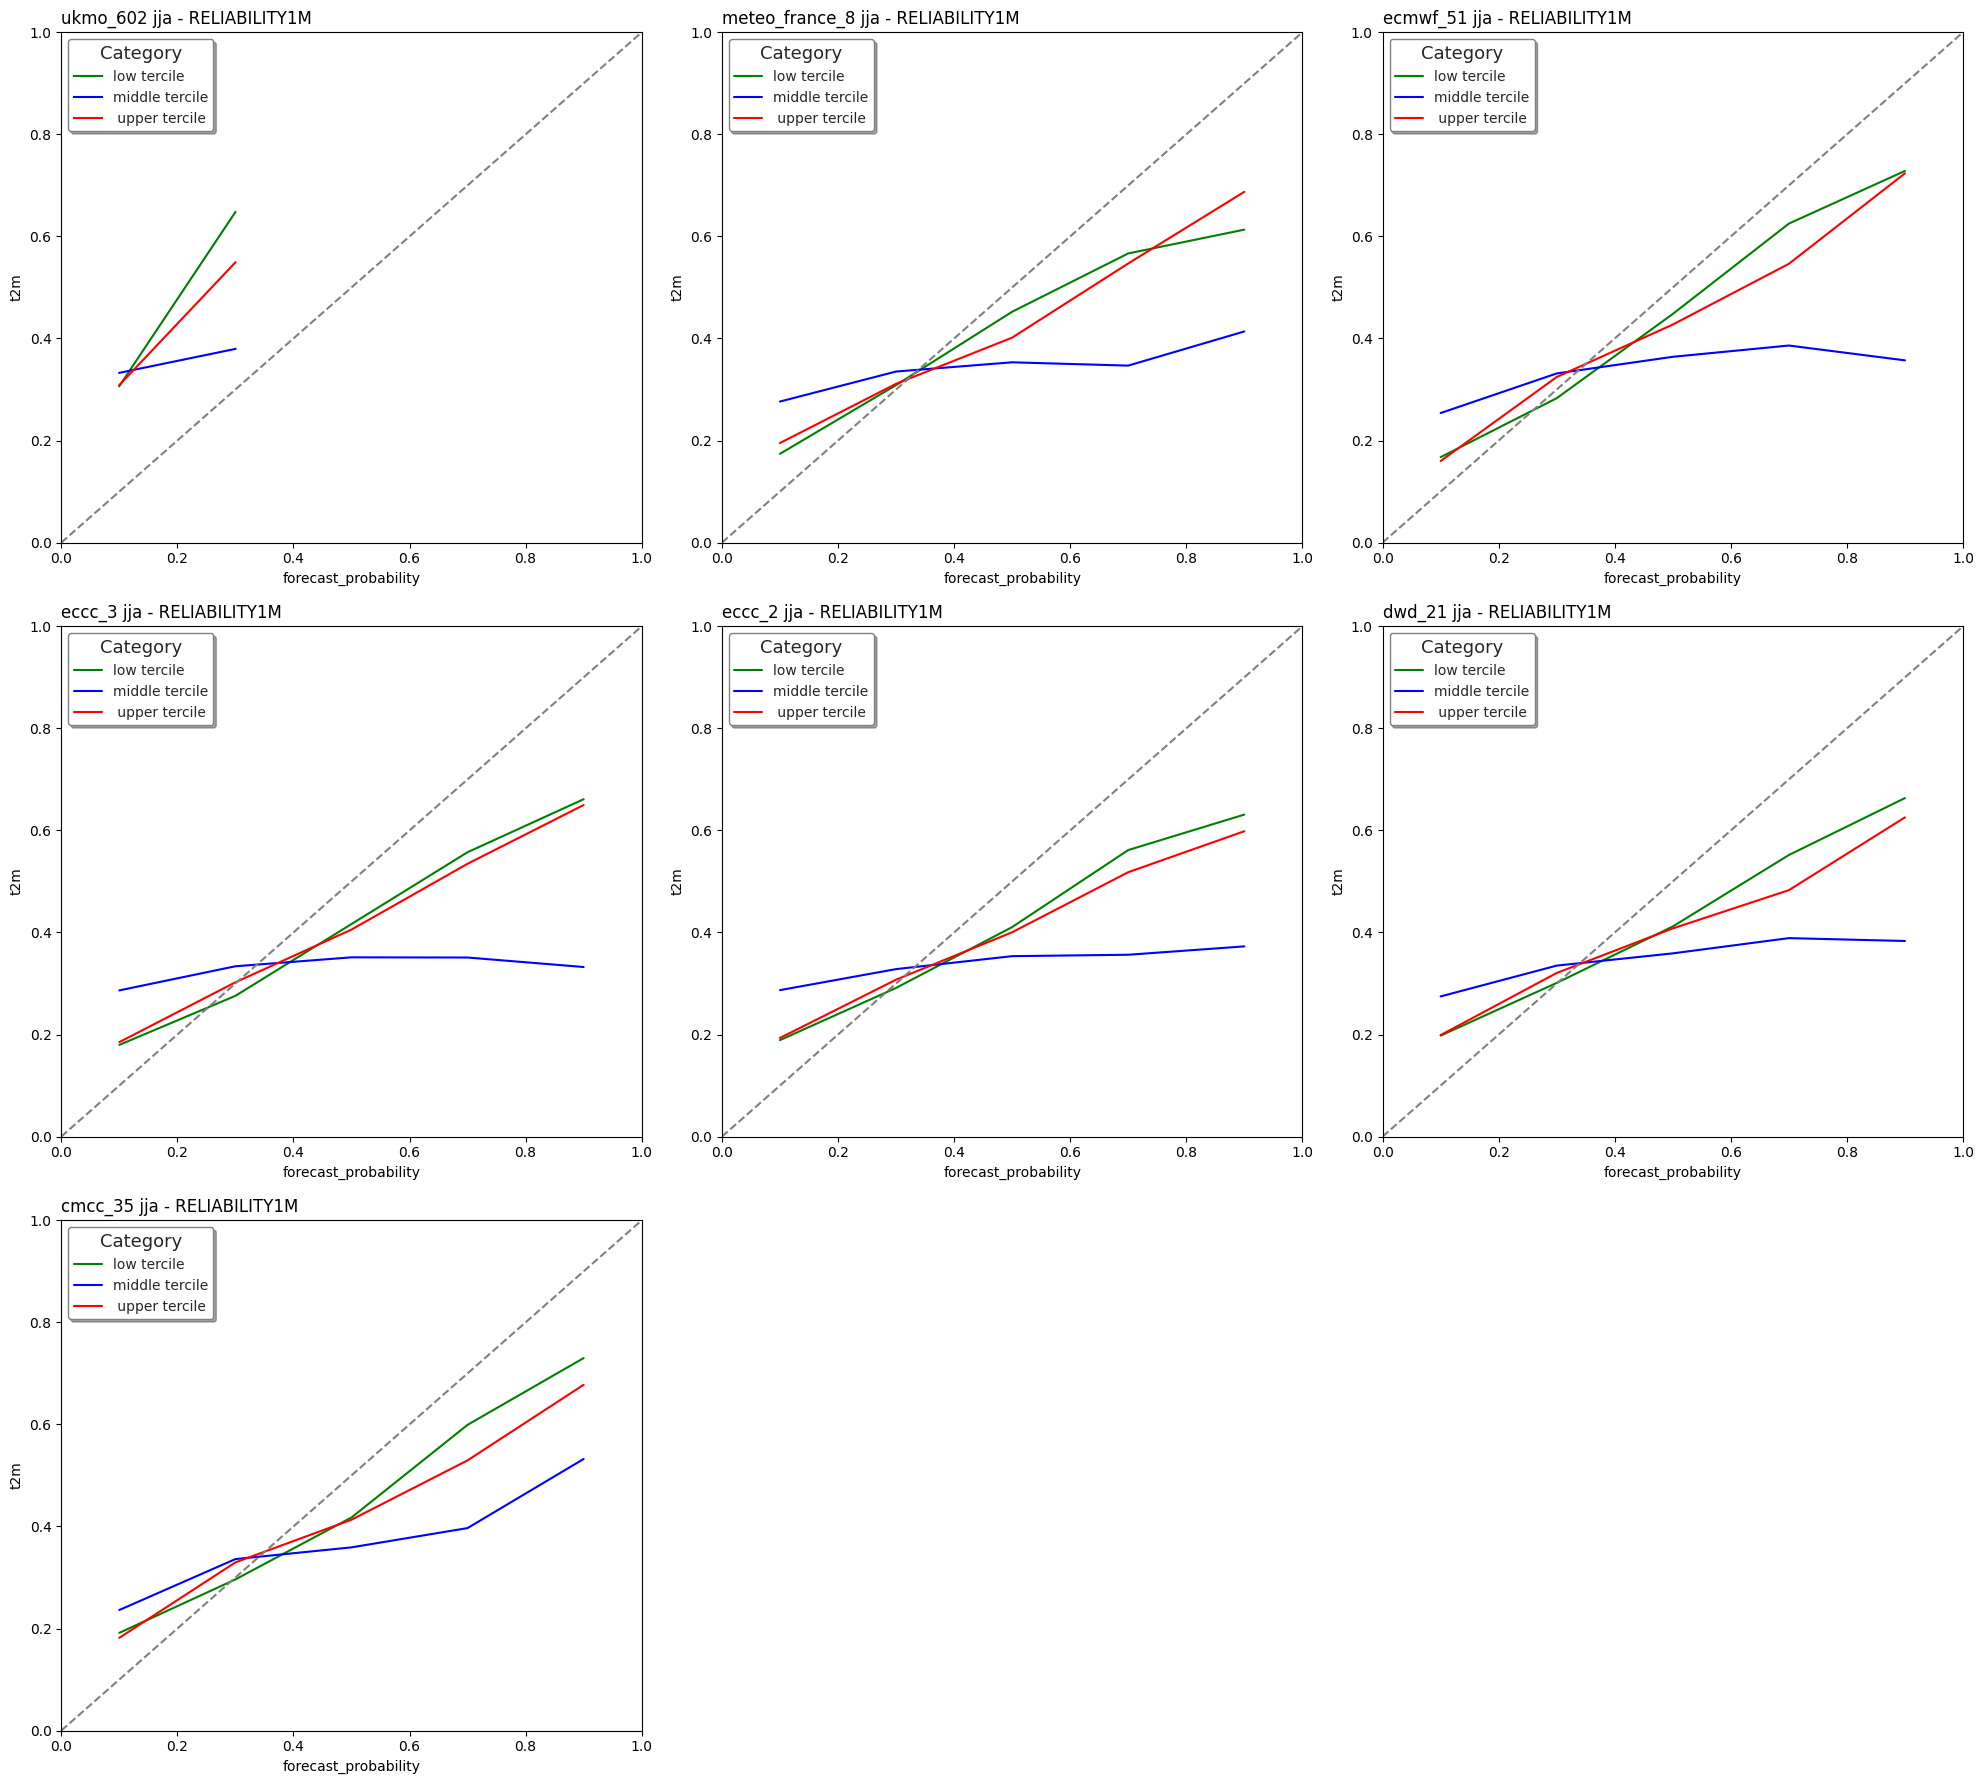

In [29]:
def plot_rela(aggr,period):

    

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols



    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))

    axes = axes.flatten()



    for i in range(n_files):

        metric="rela"

        center = available_files[i]



        # rela = xr.open_dataset(f'{SCOREDIR}/scores/{center}{details}.{aggr}.rela.nc')

        # rela=load_data_proba

        rela=load_data_proba(available_files[i], aggr, metric,period)

        

        df = rela.mean(dim=["lon", "lat", "forecastMonth"], skipna=True).to_dataframe().reset_index()

        df["category"] = df["category"].map({0: "low tercile", 1: "middle tercile", 2: " upper tercile"})



        # df["lead_time"] = df["category"].map({0: "December", 1: "January", 2: "February"})



        thisrela = df

        origin_labels = {"institution": center}

        

        tit_line1 = '{institution} '.format(**origin_labels) + f'{period}'

        tit_line2_base = 'RELIABILITY'



        if aggr == '1m':

            tit_line2 = tit_line2_base + '1M'

        elif aggr == '3m':

            tit_line2 = tit_line2_base + '3M'

        else:

            raise ValueError(f'Unexpected aggregation {aggr}')



        sns.lineplot(data=thisrela, x="forecast_probability",palette=["green", "blue", "red"], y="t2m", hue="category", ax=axes[i])

        sns.set_theme(style="whitegrid")  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'

        sns.set_context("notebook")  # Options: 'paper', 'notebook', 'talk', 'poster'

# Blues , Greens , Reds , 



        # Add diagonal line for reference

        axes[i].plot([0, 1], [0, 1], transform=axes[i].transAxes, color='gray', linestyle='--')



        # Set the title for each plot

        axes[i].set_title(f'{tit_line1} - {tit_line2}', loc='left')





        axes[i].legend(

            title="Category",   # Legend title

            title_fontsize='13', # Legend title font size

            loc='upper left',   # Position of the legend

            fontsize='10',      # Font size of legend labels

            frameon=True,       # Add a frame around the legend

            shadow=True,        # Optional shadow

            facecolor='white',  # Background color of the legend box

            edgecolor='gray'    # Border color

        )

        axes[i].set_xlim([0,1])

        axes[i].set_ylim([0,1])



    # Remove any unused axes if there are fewer files than available axes

    for j in range(n_files, len(axes)):

        fig.delaxes(axes[j])



    # Adjust the layout and display the plot only once

    plt.tight_layout()

    plt.xlim([0,1])

    plt.ylim([0,1])

    # plt.savefig(f'/home/mohamed/EHTPIII/MODELISATION/output/plots/rela/rela_diagram_{period}', dpi=300)

    plt.show()



# Define the dropdown widget for selecting aggregation

aggr_droptown = widgets.Dropdown(options=["1m", "3m"], value="1m", description="aggr")



# Create an interactive plot

widgets.interactive(plot_rela,period=period_dropdown , aggr=aggr_droptown)


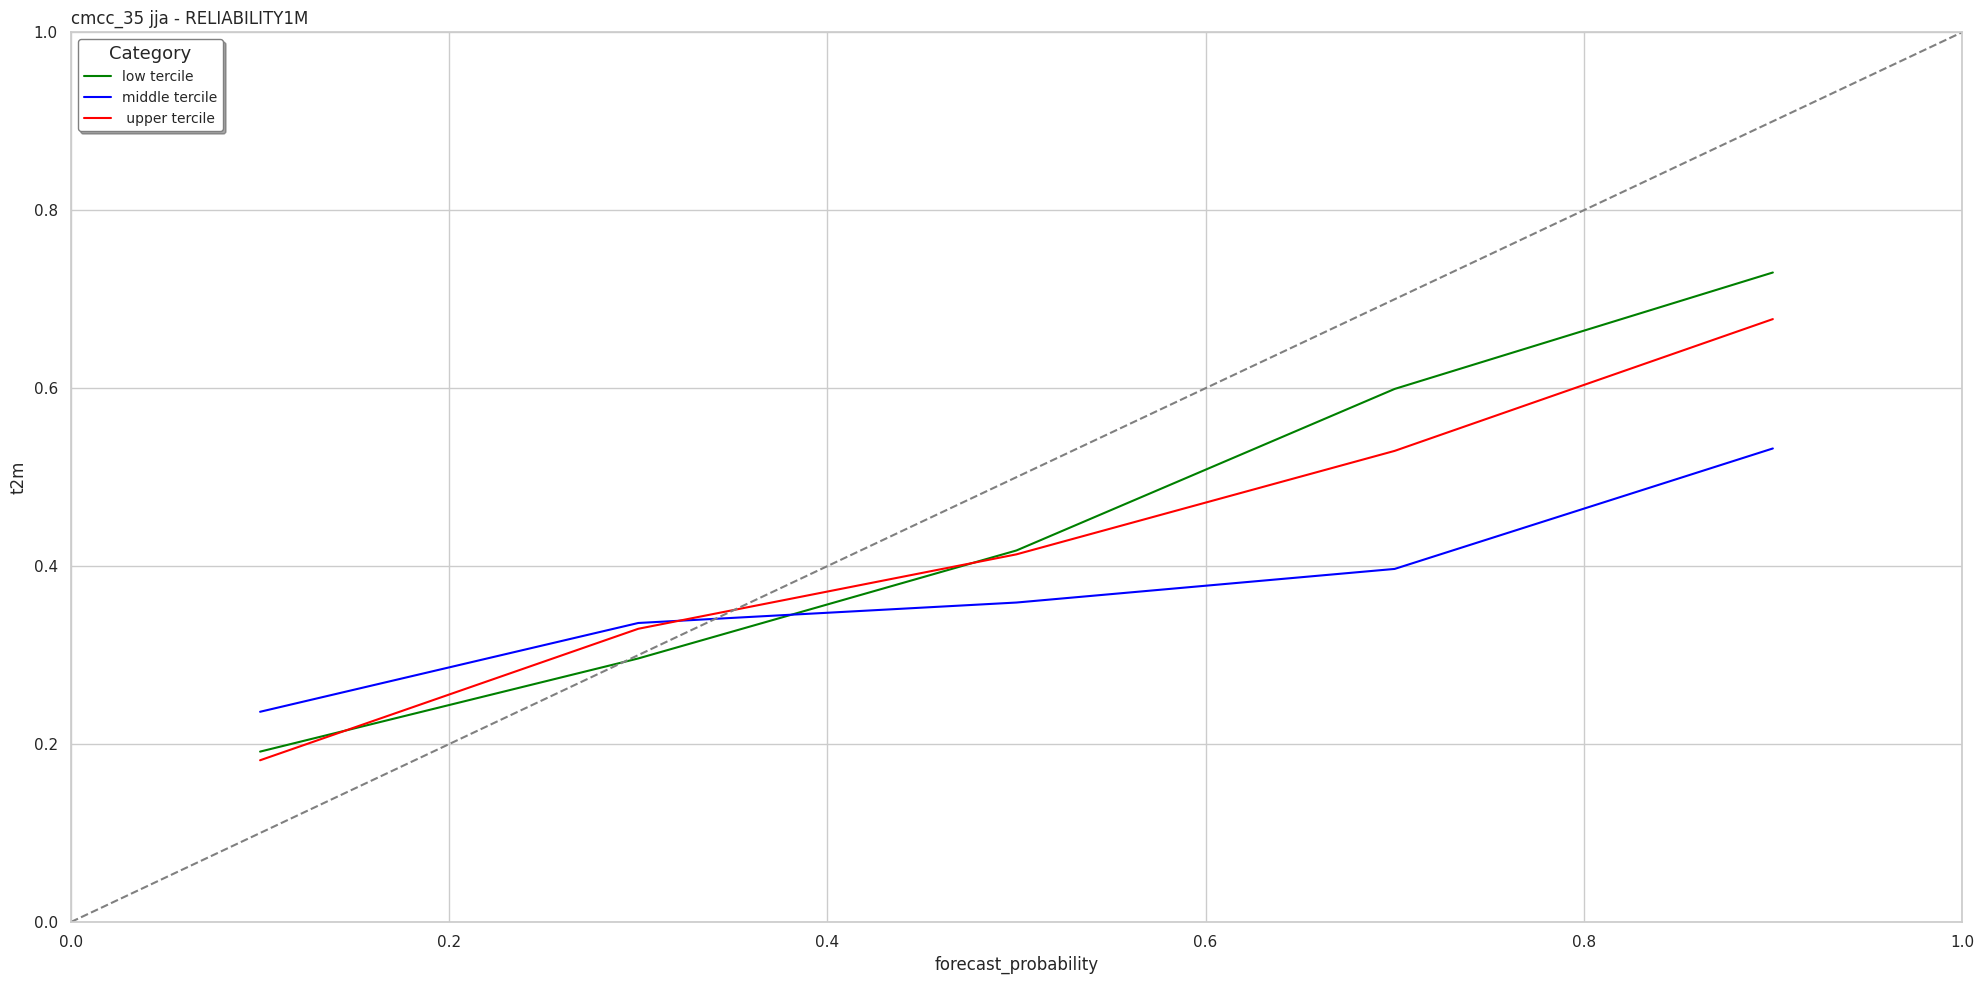

In [30]:
def plot_rela(center,aggr,period):

    

    n_files = len(available_files)

    n_cols = 3

    n_rows = (n_files + n_cols - 1) // n_cols



    fig, axes = plt.subplots(figsize=(20, 10 ))



    # rela = xr.open_dataset(f'{SCOREDIR}/scores/{center}{details}.{aggr}.rela.nc')

    metric="rela"

    rela=load_data_proba(center, aggr, metric,period)

    

    df = rela.mean(dim=["lon", "lat", "forecastMonth"], skipna=True).to_dataframe().reset_index()



    df["category"] = df["category"].map({0: "low tercile", 1: "middle tercile", 2: " upper tercile"})



    thisrela = df

    origin_labels = {"institution": center}

    

    tit_line1 = '{institution} '.format(**origin_labels) +f'{period}'

    tit_line2_base = 'RELIABILITY'



    if aggr == '1m':

        tit_line2 = tit_line2_base + '1M'

    elif aggr == '3m':

        tit_line2 = tit_line2_base + '3M'

    else:

        raise ValueError(f'Unexpected aggregation {aggr}')



    sns.lineplot(data=thisrela, x="forecast_probability",palette=["green", "blue", "red"], y="t2m", hue="category", ax=axes)

    sns.set_theme(style="whitegrid")  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'

    sns.set_context("notebook")  # Options: 'paper', 'notebook', 'talk', 'poster'

# Blues , Greens , Reds , 



    axes.plot([0, 1], [0, 1], transform=axes.transAxes, color='gray', linestyle='--')



    # Set the title for each plot

    axes.set_title(f'{tit_line1} - {tit_line2}', loc='left')





    axes.legend(

        title="Category",   # Legend title

        title_fontsize='13', # Legend title font size

        loc='upper left',   # Position of the legend

        fontsize='10',      # Font size of legend labels

        frameon=True,       # Add a frame around the legend

        shadow=True,        # Optional shadow

        facecolor='white',  # Background color of the legend box

        edgecolor='gray'    # Border color

    )

    plt.xlim([0,1])

    plt.ylim([0,1])



    plt.tight_layout()

    # plt.savefig(f'/home/mohamed/EHTPIII/MODELISATION/output/plots/{metric}/{tit_line1}_{tit_line2}', dpi=300)

    plt.show()



# Define the dropdown widget for selecting aggregation

aggr_droptown = widgets.Dropdown(options=["1m", "3m"], value="1m", description="aggr")

file_droptown=widgets.Dropdown(options=available_files,value="cmcc_35",description="Center")



# Create an interactive plot

widgets.interactive(plot_rela, period=period_dropdown,aggr=aggr_droptown,center=file_droptown)